# RNN

In [1]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version은 코랩 명령입니다.
    %tensorflow_version 2.x
except Exception:
    pass

# 이 노트북은 텐서플로 ≥2.4이 필요합니다
# 2.x 버전은 대부분 동일한 결과를 만들지만 몇 가지 버그가 있습니다.
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.4"

# 공통 모듈 임포트
import numpy as np
import pandas as pd

import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)
tf.random.set_seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "RNN"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    
import warnings
warnings.filterwarnings(action='ignore')

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False
    
if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")


No GPU was detected. CNNs can be very slow without a GPU.


## 시계열 예측

### 시계열 데이터를 생성해주는 함수

In [17]:
def generate_time_series(batch_size, n_steps):
    #4개의 10000, 1짜리 배열을 생성
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # + noise

    return series[..., np.newaxis].astype(np.float32)

### 훈련 세트, 검증 세트, 테스트 세트 데이터 생성

In [18]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 1)
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]

(10000, 51)
(10000, 51)
(10000, 51)
(10000, 51, 1)


In [4]:
X_train.shape, y_train.shape

((7000, 50, 1), (7000, 1))

### 데이터 확인

그림 저장: time_series_plot


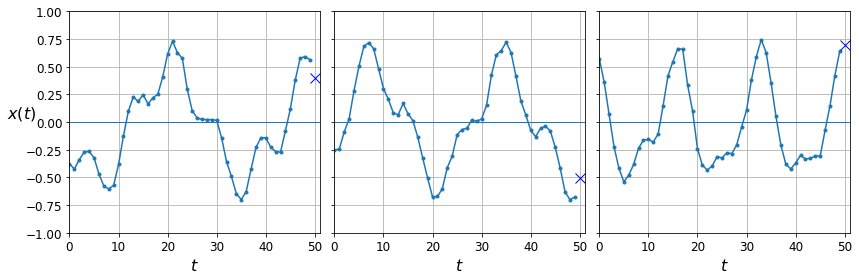

In [5]:
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$"):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bx", markersize=10)
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "ro")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])

fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(X_valid[col, :, 0], y_valid[col, 0],
                y_label=("$x(t)$" if col==0 else None))
save_fig("time_series_plot")
plt.show()

### 순진한 예측

In [30]:
y_pred = X_valid[:, -1]
np.mean(keras.losses.mean_squared_error(y_valid, y_pred))

(2000, 1)
[-0.16023138]


0.020211367

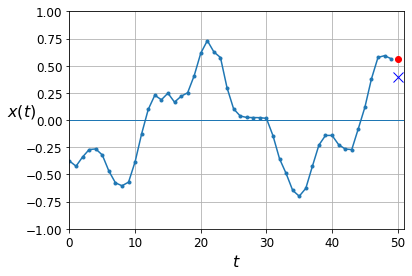

In [7]:
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

### 완전 연결 네트워크 사용

In [8]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

2021-07-22 08:18:02.288500: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20
219/219 [==============================] - 0s 1ms/step - loss: 0.1001 - val_loss: 0.0545
Epoch 2/20
219/219 [==============================] - 0s 731us/step - loss: 0.0379 - val_loss: 0.0266
Epoch 3/20
219/219 [==============================] - 0s 678us/step - loss: 0.0202 - val_loss: 0.0157
Epoch 4/20
219/219 [==============================] - 0s 678us/step - loss: 0.0131 - val_loss: 0.0116
Epoch 5/20
219/219 [==============================] - 0s 717us/step - loss: 0.0103 - val_loss: 0.0098
Epoch 6/20
219/219 [==============================] - 0s 619us/step - loss: 0.0089 - val_loss: 0.0087
Epoch 7/20
219/219 [==============================] - 0s 737us/step - loss: 0.0080 - val_loss: 0.0079
Epoch 8/20
219/219 [==============================] - 0s 688us/step - loss: 0.0073 - val_loss: 0.0071
Epoch 9/20
219/219 [==============================] - 0s 815us/step - loss: 0.0066 - val_loss: 0.0066
Epoch 10/20
219/219 [==============================] - 0s 793us/step - loss: 0.0061 

In [9]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 438us/step - loss: 0.0042


0.004168087150901556

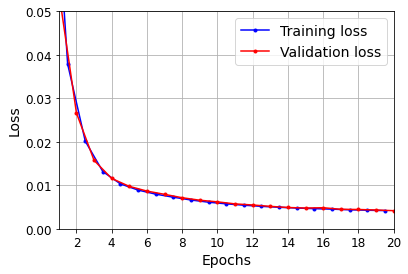

In [10]:
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 20, 0, 0.05])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

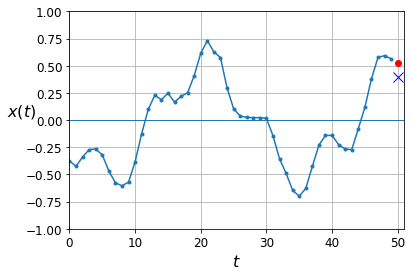

In [11]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

### 간단한 RNN 구현

In [12]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(1, input_shape=[None, 1])
])

optimizer = keras.optimizers.Adam(lr=0.005)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 2s 5ms/step - loss: 0.0967 - val_loss: 0.0489
Epoch 2/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0369 - val_loss: 0.0296
Epoch 3/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0253 - val_loss: 0.0218
Epoch 4/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0198 - val_loss: 0.0177
Epoch 5/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0166 - val_loss: 0.0151
Epoch 6/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0146 - val_loss: 0.0134
Epoch 7/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0132 - val_loss: 0.0123
Epoch 8/20
219/219 [==============================] - 1s 5ms/step - loss: 0.0124 - val_loss: 0.0116
Epoch 9/20
219/219 [==============================] - 1s 5ms/step - loss: 0.0118 - val_loss: 0.0112
Epoch 10/20
219/219 [==============================] - 1s 5ms/step - loss: 0.0116 - val_loss: 0.0110

In [13]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 3ms/step - loss: 0.0109


0.010881561785936356

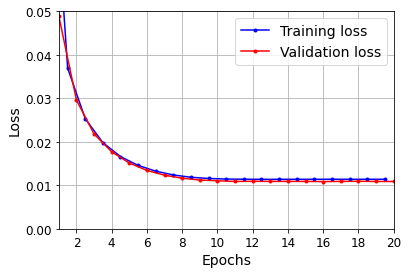

In [14]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

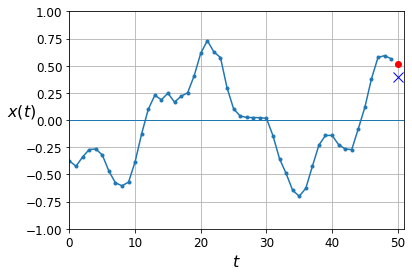

In [15]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

### 심층 RNN

In [16]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.SimpleRNN(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 6s 19ms/step - loss: 0.0492 - val_loss: 0.0090
Epoch 2/20
219/219 [==============================] - 4s 18ms/step - loss: 0.0070 - val_loss: 0.0065
Epoch 3/20
219/219 [==============================] - 4s 16ms/step - loss: 0.0053 - val_loss: 0.0045
Epoch 4/20
219/219 [==============================] - 4s 17ms/step - loss: 0.0045 - val_loss: 0.0040
Epoch 5/20
219/219 [==============================] - 4s 20ms/step - loss: 0.0042 - val_loss: 0.0040
Epoch 6/20
219/219 [==============================] - 4s 20ms/step - loss: 0.0038 - val_loss: 0.0036
Epoch 7/20
219/219 [==============================] - 4s 16ms/step - loss: 0.0038 - val_loss: 0.0040
Epoch 8/20
219/219 [==============================] - 4s 16ms/step - loss: 0.0037 - val_loss: 0.0033
Epoch 9/20
219/219 [==============================] - 3s 16ms/step - loss: 0.0036 - val_loss: 0.0032
Epoch 10/20
219/219 [==============================] - 4s 19ms/step - loss: 0.0035 - val_lo

### 출력층 변경

In [17]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 4s 15ms/step - loss: 0.0232 - val_loss: 0.0052
Epoch 2/20
219/219 [==============================] - 3s 12ms/step - loss: 0.0043 - val_loss: 0.0036
Epoch 3/20
219/219 [==============================] - 3s 12ms/step - loss: 0.0035 - val_loss: 0.0031
Epoch 4/20
219/219 [==============================] - 2s 11ms/step - loss: 0.0033 - val_loss: 0.0033
Epoch 5/20
219/219 [==============================] - 2s 11ms/step - loss: 0.0033 - val_loss: 0.0034
Epoch 6/20
219/219 [==============================] - 2s 11ms/step - loss: 0.0031 - val_loss: 0.0029
Epoch 7/20
219/219 [==============================] - 2s 11ms/step - loss: 0.0031 - val_loss: 0.0034
Epoch 8/20
219/219 [==============================] - 3s 13ms/step - loss: 0.0032 - val_loss: 0.0028
Epoch 9/20
219/219 [==============================] - 3s 12ms/step - loss: 0.0031 - val_loss: 0.0028
Epoch 10/20
219/219 [==============================] - 3s 13ms/step - loss: 0.0030 - val_lo

In [18]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 4ms/step - loss: 0.0026


0.0026236234698444605

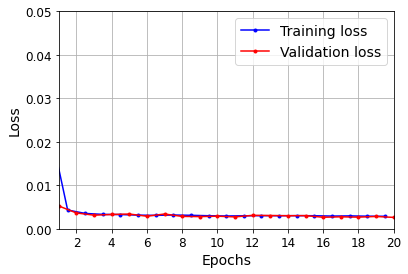

In [19]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

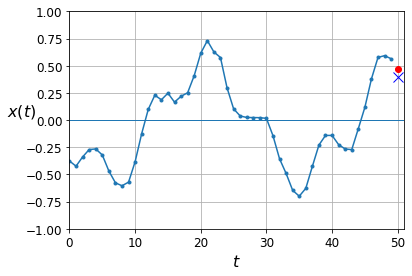

In [20]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

### 다음 10개의 값 예측하기 - 이미 훈련된 모델을 이용해서 다음 값을 예측한 다음 이 값을 입력으로 사용

In [21]:
np.random.seed(43) 

#60개의 타임 생성
series = generate_time_series(1, n_steps + 10)
#50개와 10개로 분할
X_new, Y_new = series[:, :n_steps], series[:, n_steps:]
X = X_new
for step_ahead in range(10):
    #출력되는 값을 새로운 입력으로 사용 - 차원을 늘려줌
    y_pred_one = model.predict(X[:, step_ahead:])[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:]

In [22]:
Y_pred.shape

(1, 10, 1)

그림 저장: forecast_ahead_plot


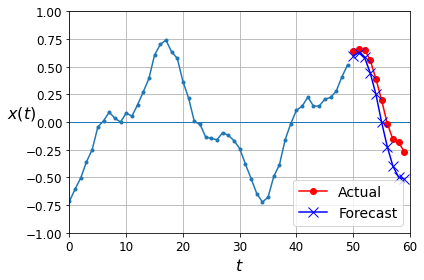

In [23]:
def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plot_series(X[0, :, 0])
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], "ro-", label="Actual")
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], "bx-", label="Forecast", markersize=10)
    plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend(fontsize=14)

plot_multiple_forecasts(X_new, Y_new, Y_pred)
save_fig("forecast_ahead_plot")
plt.show()

### 다음 10개의 값 예측하기 - 다음 값 10개를 한번에 예측

In [24]:
#타깃을 10개의 값이 담긴 벡터로 변환
n_steps = 50
series = generate_time_series(10000, n_steps + 10)

X_train, Y_train = series[:7000, :n_steps], series[:7000, -10:, 0]
X_valid, Y_valid = series[7000:9000, :n_steps], series[7000:9000, -10:, 0]
X_test, Y_test =series[9000:, :n_steps], series[9000:, -10:, 0]

In [25]:
X_train.shape, Y_train.shape

((7000, 50, 1), (7000, 10))

In [26]:
#출력 층을 10개로 변환
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(10)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 4s 13ms/step - loss: 0.1586 - val_loss: 0.1524
Epoch 2/20
219/219 [==============================] - 3s 12ms/step - loss: 0.1463 - val_loss: 0.1520
Epoch 3/20
219/219 [==============================] - 3s 14ms/step - loss: 0.1458 - val_loss: 0.1522
Epoch 4/20
219/219 [==============================] - 3s 14ms/step - loss: 0.1456 - val_loss: 0.1519
Epoch 5/20
219/219 [==============================] - 3s 14ms/step - loss: 0.1455 - val_loss: 0.1518
Epoch 6/20
219/219 [==============================] - 3s 14ms/step - loss: 0.1454 - val_loss: 0.1520
Epoch 7/20
219/219 [==============================] - 3s 13ms/step - loss: 0.1454 - val_loss: 0.1517
Epoch 8/20
219/219 [==============================] - 4s 19ms/step - loss: 0.1454 - val_loss: 0.1518
Epoch 9/20
219/219 [==============================] - 3s 12ms/step - loss: 0.1453 - val_loss: 0.1517
Epoch 10/20
219/219 [==============================] - 3s 12ms/step - loss: 0.1453 - val_lo

In [27]:
Y_pred = model.predict(X_new)

In [28]:
print(Y_pred)

[[0.05024451 0.04407897 0.04244822 0.04783368 0.04137526 0.0454284
  0.04316386 0.03426635 0.0404944  0.04521111]]


### 개선 - 시퀀스 투 시퀀스 RNN 모델

In [29]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)

X_train = series[:7000, :n_steps]
X_valid = series[7000:9000, :n_steps]
X_test = series[9000:, :n_steps]
#각 타겟은 10D 벡터의 시퀀스
Y = np.empty((10000, n_steps, 10))
for step_ahead in range(1, 10 + 1):
    Y[..., step_ahead - 1] = series[..., step_ahead:step_ahead + n_steps, 0]
Y_train = Y[:7000]
Y_valid = Y[7000:9000]
Y_test = Y[9000:]

X_train.shape, Y_train.shape

((7000, 50, 1), (7000, 50, 10))

In [30]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])


#모든 출력에서 MSE를 검사하기 위한 함수
def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

model.compile(loss="mse", optimizer=keras.optimizers.Adam(lr=0.01), metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 5s 18ms/step - loss: 0.0508 - last_time_step_mse: 0.0400 - val_loss: 0.0429 - val_last_time_step_mse: 0.0324
Epoch 2/20
219/219 [==============================] - 4s 16ms/step - loss: 0.0395 - last_time_step_mse: 0.0283 - val_loss: 0.0366 - val_last_time_step_mse: 0.0264
Epoch 3/20
219/219 [==============================] - 3s 15ms/step - loss: 0.0323 - last_time_step_mse: 0.0212 - val_loss: 0.0343 - val_last_time_step_mse: 0.0244
Epoch 4/20
219/219 [==============================] - 4s 18ms/step - loss: 0.0297 - last_time_step_mse: 0.0186 - val_loss: 0.0284 - val_last_time_step_mse: 0.0164
Epoch 5/20
219/219 [==============================] - 5s 21ms/step - loss: 0.0274 - last_time_step_mse: 0.0153 - val_loss: 0.0282 - val_last_time_step_mse: 0.0196
Epoch 6/20
219/219 [==============================] - 5s 22ms/step - loss: 0.0251 - last_time_step_mse: 0.0126 - val_loss: 0.0215 - val_last_time_step_mse: 0.0081
Epoch 7/20
219/219 [==

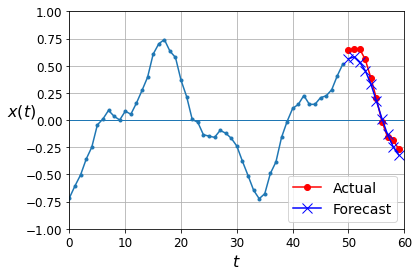

In [31]:
#예측과 시각화
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

## 긴 시퀀스 다루기 - Deep RNNs with Layer Norm

### 배치 정규화 적용

In [32]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.BatchNormalization(),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.BatchNormalization(),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 6s 22ms/step - loss: 0.1929 - last_time_step_mse: 0.1902 - val_loss: 0.0877 - val_last_time_step_mse: 0.0832
Epoch 2/20
219/219 [==============================] - 4s 18ms/step - loss: 0.0537 - last_time_step_mse: 0.0449 - val_loss: 0.0549 - val_last_time_step_mse: 0.0462
Epoch 3/20
219/219 [==============================] - 4s 18ms/step - loss: 0.0471 - last_time_step_mse: 0.0375 - val_loss: 0.0451 - val_last_time_step_mse: 0.0358
Epoch 4/20
219/219 [==============================] - 4s 19ms/step - loss: 0.0437 - last_time_step_mse: 0.0337 - val_loss: 0.0418 - val_last_time_step_mse: 0.0314
Epoch 5/20
219/219 [==============================] - 4s 19ms/step - loss: 0.0409 - last_time_step_mse: 0.0306 - val_loss: 0.0391 - val_last_time_step_mse: 0.0287
Epoch 6/20
219/219 [==============================] - 4s 19ms/step - loss: 0.0385 - last_time_step_mse: 0.0275 - val_loss: 0.0379 - val_last_time_step_mse: 0.0273
Epoch 7/20
219/219 [==

### 층 정규화

In [33]:
from tensorflow.keras.layers import LayerNormalization

class LNSimpleRNNCell(keras.layers.Layer):
    def __init__(self, units, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.state_size = units
        self.output_size = units
        self.simple_rnn_cell = keras.layers.SimpleRNNCell(units,
                                                          activation=None)
        self.layer_norm = LayerNormalization()
        self.activation = keras.activations.get(activation)
        
    def get_initial_state(self, inputs=None, batch_size=None, dtype=None):
        if inputs is not None:
            batch_size = tf.shape(inputs)[0]
            dtype = inputs.dtype
        return [tf.zeros([batch_size, self.state_size], dtype=dtype)]
    
    def call(self, inputs, states):
        outputs, new_states = self.simple_rnn_cell(inputs, states)
        norm_outputs = self.activation(self.layer_norm(outputs))
        return norm_outputs, [norm_outputs]

In [34]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True,
                     input_shape=[None, 1]),
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 8s 28ms/step - loss: 0.1591 - last_time_step_mse: 0.1499 - val_loss: 0.0734 - val_last_time_step_mse: 0.0624
Epoch 2/20
219/219 [==============================] - 5s 25ms/step - loss: 0.0638 - last_time_step_mse: 0.0505 - val_loss: 0.0566 - val_last_time_step_mse: 0.0423
Epoch 3/20
219/219 [==============================] - 6s 26ms/step - loss: 0.0531 - last_time_step_mse: 0.0375 - val_loss: 0.0509 - val_last_time_step_mse: 0.0342
Epoch 4/20
219/219 [==============================] - 5s 25ms/step - loss: 0.0471 - last_time_step_mse: 0.0311 - val_loss: 0.0442 - val_last_time_step_mse: 0.0286
Epoch 5/20
219/219 [==============================] - 6s 26ms/step - loss: 0.0428 - last_time_step_mse: 0.0273 - val_loss: 0.0418 - val_last_time_step_mse: 0.0258
Epoch 6/20
219/219 [==============================] - 6s 26ms/step - loss: 0.0395 - last_time_step_mse: 0.0243 - val_loss: 0.0382 - val_last_time_step_mse: 0.0229
Epoch 7/20
219/219 [==

## 임베딩 레이어를 활용한 Simple RNN

### 임베딩 레이어 생성

In [35]:
# 라이브러리 불러오기
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding

# 임베딩 레이어
embedding_layer = Embedding(100, 3)
result = embedding_layer(tf.constant([12, 8, 15, 20])) #더미 데이터 입력
print(result)

tf.Tensor(
[[ 0.04166089 -0.01959355 -0.01119081]
 [ 0.04439995 -0.00468044  0.02687681]
 [ 0.02107911 -0.0075531   0.00174569]
 [ 0.04589696  0.03758806  0.02840484]], shape=(4, 3), dtype=float32)


In [36]:
# 임베딩 레이어 활용
model = Sequential()
model.add(tf.keras.layers.Embedding(100, 3, input_length=32))
model.add(tf.keras.layers.LSTM(units=32))
model.add(tf.keras.layers.Dense(units=1))
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 32, 3)             300       
_________________________________________________________________
lstm (LSTM)                  (None, 32)                4608      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 33        
Total params: 4,941
Trainable params: 4,941
Non-trainable params: 0
_________________________________________________________________


## 양방향 RNN

In [37]:
# Bidirectional LSTM
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import LSTM, Dense

model = Sequential()
model.add(Embedding(100,3))
model.add(Bidirectional(LSTM(32))) # 양방향 RNN
model.add(Dense(1))
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 3)           300       
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                9216      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 65        
Total params: 9,581
Trainable params: 9,581
Non-trainable params: 0
_________________________________________________________________


## 스태킹 RNN

In [38]:
# 스태킹RNN 예제
model = Sequential()
model.add(Embedding(100,32))
model.add(LSTM(32, return_sequences=True))  # 전체 시퀀스 출력 (batch_size, timesteps, units)
model.add(LSTM(32))
model.add(Dense(1))
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 32)          3200      
_________________________________________________________________
lstm_2 (LSTM)                (None, None, 32)          8320      
_________________________________________________________________
lstm_3 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 33        
Total params: 19,873
Trainable params: 19,873
Non-trainable params: 0
_________________________________________________________________


## 순환 드롭아웃

In [39]:
# 순환 드룹아웃
model = Sequential()
model.add(Embedding(100, 32))
model.add(LSTM(32, recurrent_dropout=0.2, dropout=0.2))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 32)          3200      
_________________________________________________________________
lstm_4 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 33        
Total params: 11,553
Trainable params: 11,553
Non-trainable params: 0
_________________________________________________________________


## 자연어 처리

### 토큰화

In [40]:
# 텐서플로 토크나이저
from tensorflow.keras.preprocessing.text import Tokenizer
sentences = [
             '영실이는 나를 정말 정말 좋아해',
             '영실이는 영화를 좋아해'
]
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)
print("단어 인덱스:",tokenizer.word_index)

단어 인덱스: {'영실이는': 1, '정말': 2, '좋아해': 3, '나를': 4, '영화를': 5}


### 인코딩 결과

In [41]:
# 인코딩된 결과
word_encoding = tokenizer.texts_to_sequences(sentences)
word_encoding

[[1, 4, 2, 2, 3], [1, 5, 3]]

### 사전에 없는 단어

In [42]:
# 사전에 없는 단어가 있을 때 인코딩 결과
new_sentences = ['영실이는 경록이와 나를 좋아해']
new_word_encoding = tokenizer.texts_to_sequences(new_sentences)
new_word_encoding

[[1, 4, 3]]

### 사전에 없는(Out Of Vocabulary) 단어 처리

In [43]:
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(sentences)
word_index = tokenizer.word_index

new_word_encoding = tokenizer.texts_to_sequences(new_sentences)

print(word_index)
print(new_word_encoding)

{'<OOV>': 1, '영실이는': 2, '정말': 3, '좋아해': 4, '나를': 5, '영화를': 6}
[[2, 1, 5, 4]]


### 단어사전 개수 설정

In [44]:
#앞의 2개 단어만 이용해서 단어를 찾음
tokenizer = Tokenizer(num_words=3, oov_token="<OOV>")
tokenizer.fit_on_texts(sentences)
word_index = tokenizer.word_index
new_word_encoding = tokenizer.texts_to_sequences(new_sentences)
print(word_index)
print(new_word_encoding)

{'<OOV>': 1, '영실이는': 2, '정말': 3, '좋아해': 4, '나를': 5, '영화를': 6}
[[2, 1, 1, 1]]


### 문장의 길이 맞추기

In [45]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
padded = pad_sequences(word_encoding)
print(padded)

[[1 4 2 2 3]
 [0 0 1 5 3]]


In [46]:
# 패딩(뒤에 0 붙이기)
padded = pad_sequences(word_encoding, padding='post')
print(padded)

[[1 4 2 2 3]
 [1 5 3 0 0]]


In [47]:
# 문장의 최대 길이 고정
padded = pad_sequences(word_encoding, padding='post',maxlen=4)
print(padded)

[[4 2 2 3]
 [1 5 3 0]]


In [48]:
# 최대 길이보다 문장이 길 때 뒷부분 자르기
padded = pad_sequences(word_encoding, padding='post', truncating='post', maxlen=4)
print(padded)

[[1 4 2 2]
 [1 5 3 0]]


## Simple RNN 을 이용한 스팸 메일 분류

### import

In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import urllib.request
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

### 데이터 가져오기

In [2]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/mohitgupta-omg/Kaggle-SMS-Spam-Collection-Dataset-/master/spam.csv", filename="spam.csv")
data = pd.read_csv('spam.csv',encoding='latin1')

### 데이터 확인

In [3]:
print('총 샘플의 수 :',len(data))

총 샘플의 수 : 5572


In [4]:
data[:5]

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


### 불필요한 열 제거

In [5]:
del data['Unnamed: 2']
del data['Unnamed: 3']
del data['Unnamed: 4']
data['v1'] = data['v1'].replace(['ham','spam'],[0,1])
data[:5]

,v1,v2
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


### 데이터 정보 확인

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   v1      5572 non-null   int64 
 1   v2      5572 non-null   object
dtypes: int64(1), object(1)
memory usage: 87.2+ KB


In [7]:
#null 존재 여부 확인
data.isnull().values.any()

False

In [8]:
#데이터의 중복 확인
data['v2'].nunique(), data['v1'].nunique()

(5169, 2)

### 중복 제거

In [9]:
data.drop_duplicates(subset=['v2'], inplace=True) # v2 열에서 중복인 내용이 있다면 중복 제거

In [10]:
print('총 샘플의 수 :',len(data))
data['v2'].nunique(), data['v1'].nunique()

총 샘플의 수 : 5169


(5169, 2)

### 데이터 분포 확인

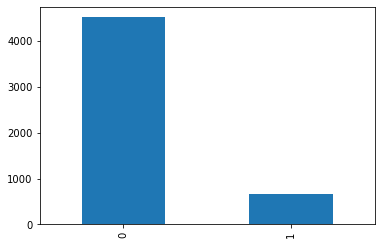

In [11]:
data['v1'].value_counts().plot(kind='bar')

In [12]:
print(data.groupby('v1').size().reset_index(name='count'))

   v1  count
0   0   4516
1   1    653


### 피처와 레이블 분리

In [13]:
X_data = data['v2']
y_data = data['v1']
print('메일 본문의 개수: {}'.format(len(X_data)))
print('레이블의 개수: {}'.format(len(y_data)))

메일 본문의 개수: 5169
레이블의 개수: 5169


### 토큰화 숫자화 수행

In [14]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_data) # 5169개의 행을 가진 X의 각 행에 토큰화를 수행
sequences = tokenizer.texts_to_sequences(X_data) # 단어를 숫자값, 인덱스로 변환하여 저장

In [15]:
print(sequences[:5])

[[47, 433, 4013, 780, 705, 662, 64, 8, 1202, 94, 121, 434, 1203, 142, 2712, 1204, 68, 57, 4014, 137], [49, 306, 1364, 435, 6, 1767], [53, 537, 8, 20, 4, 1016, 934, 2, 220, 2713, 1365, 706, 2714, 2715, 267, 2716, 70, 2713, 2, 2717, 2, 359, 537, 604, 1205, 82, 436, 185, 707, 437, 4015], [6, 226, 152, 23, 347, 2718, 6, 138, 145, 56, 152], [935, 1, 97, 96, 69, 453, 2, 877, 69, 1768, 198, 105, 438]]


In [16]:
#인덱스 확인
word_to_index = tokenizer.word_index
print(word_to_index)

{'i': 1, 'to': 2, 'you': 3, 'a': 4, 'the': 5, 'u': 6, 'and': 7, 'in': 8, 'is': 9, 'me': 10, 'my': 11, 'for': 12, 'your': 13, 'it': 14, 'of': 15, 'have': 16, 'call': 17, 'that': 18, 'on': 19, '2': 20, 'are': 21, 'now': 22, 'so': 23, 'but': 24, 'not': 25, 'can': 26, 'at': 27, 'or': 28, "i'm": 29, 'do': 30, 'be': 31, 'get': 32, 'will': 33, 'just': 34, 'if': 35, 'with': 36, 'we': 37, 'no': 38, 'this': 39, 'ur': 40, 'up': 41, 'gt': 42, 'lt': 43, '4': 44, 'how': 45, 'when': 46, 'go': 47, 'from': 48, 'ok': 49, 'out': 50, 'all': 51, 'what': 52, 'free': 53, 'know': 54, 'like': 55, 'then': 56, 'got': 57, 'good': 58, 'come': 59, 'am': 60, 'was': 61, 'time': 62, 'its': 63, 'only': 64, 'day': 65, 'want': 66, 'love': 67, 'there': 68, 'he': 69, 'text': 70, 'send': 71, 'going': 72, 'one': 73, 'need': 74, 'by': 75, 'lor': 76, 'home': 77, 'as': 78, 'about': 79, 'still': 80, 'see': 81, 'txt': 82, 'back': 83, 'r': 84, 'stop': 85, 'da': 86, 'k': 87, 'today': 88, 'our': 89, "i'll": 90, 'dont': 91, 'reply': 

### 단어의 빈도수 확인

In [17]:
threshold = 2
total_cnt = len(word_to_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합(vocabulary)에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

등장 빈도가 1번 이하인 희귀 단어의 수: 4908
단어 집합(vocabulary)에서 희귀 단어의 비율: 55.02242152466368
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 6.082538108811501


### 단어 집합의 크기 설정

In [18]:
vocab_size = len(word_to_index) + 1
print('단어 집합의 크기: {}'.format((vocab_size)))

단어 집합의 크기: 8921


### 메일의 길이 확인

메일의 최대 길이 : 189
메일의 평균 길이 : 15.610370


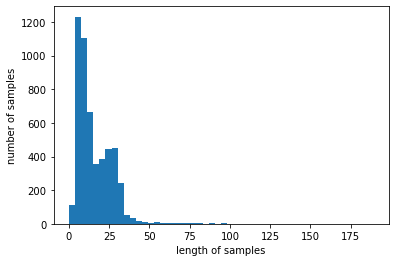

In [21]:
X_data = sequences
print('메일의 최대 길이 : %d' % max(len(l) for l in X_data))
print('메일의 평균 길이 : %f' % (sum(map(len, X_data))/len(X_data)))
plt.hist([len(s) for s in X_data], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

### 문장에 패딩 적용

In [22]:
max_len = 189
# 전체 데이터셋의 길이는 max_len으로 맞춥니다.
data = pad_sequences(X_data, maxlen = max_len)
print("훈련 데이터의 크기(shape): ", data.shape)

훈련 데이터의 크기(shape):  (5169, 189)


### 훈련 데이터 와 테스트 데이터 분리

In [23]:
n_of_train = int(len(sequences) * 0.8)
n_of_test = int(len(sequences) - n_of_train)
print('훈련 데이터의 개수 :',n_of_train)
print('테스트 데이터의 개수:',n_of_test)

X_test = data[n_of_train:] #X_data 데이터 중에서 뒤의 1034개의 데이터만 저장
y_test = np.array(y_data[n_of_train:]) #y_data 데이터 중에서 뒤의 1034개의 데이터만 저장
X_train = data[:n_of_train] #X_data 데이터 중에서 앞의 4135개의 데이터만 저장
y_train = np.array(y_data[:n_of_train]) #y_data 데이터 중에서 앞의 4135개의 데이터만 저장

### 모델 생성 및 훈련

In [27]:
from tensorflow.keras.layers import SimpleRNN, Embedding, Dense
from tensorflow.keras.models import Sequential

model = Sequential()
model.add(Embedding(vocab_size, 32)) # 임베딩 벡터의 차원은 32
model.add(SimpleRNN(32)) # RNN 셀의 hidden_size는 32
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2)

Epoch 1/10
52/52 [==============================] - 3s 39ms/step - loss: 0.4307 - acc: 0.8102 - val_loss: 0.3816 - val_acc: 0.9335
Epoch 2/10
52/52 [==============================] - 2s 37ms/step - loss: 0.3605 - acc: 0.8365 - val_loss: 0.2976 - val_acc: 0.9383
Epoch 3/10
52/52 [==============================] - 2s 31ms/step - loss: 0.1621 - acc: 0.9731 - val_loss: 0.1163 - val_acc: 0.9674
Epoch 4/10
52/52 [==============================] - 2s 30ms/step - loss: 0.0633 - acc: 0.9825 - val_loss: 0.0867 - val_acc: 0.9722
Epoch 5/10
52/52 [==============================] - 2s 30ms/step - loss: 0.0342 - acc: 0.9909 - val_loss: 0.0823 - val_acc: 0.9698
Epoch 6/10
52/52 [==============================] - 2s 30ms/step - loss: 0.0222 - acc: 0.9937 - val_loss: 0.0747 - val_acc: 0.9770
Epoch 7/10
52/52 [==============================] - 2s 33ms/step - loss: 0.0146 - acc: 0.9961 - val_loss: 0.0641 - val_acc: 0.9794
Epoch 8/10
52/52 [==============================] - 2s 30ms/step - loss: 0.0076 - a

In [28]:
print("\n 테스트 정확도: %.4f" % (model.evaluate(X_test, y_test)[1]))

33/33 [==============================] - 0s 9ms/step - loss: 0.0912 - acc: 0.9778

 테스트 정확도: 0.9778


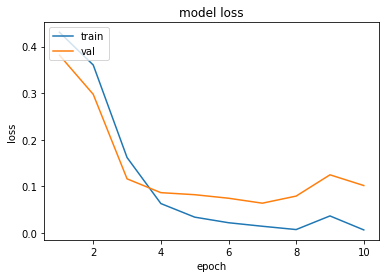

In [29]:
epochs = range(1, len(history.history['acc']) + 1)
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## 순환 신경망으로 IMDB 리뷰 분류하기

### 자주 사용하는 단어 500개 가져오기

In [49]:
from tensorflow.keras.datasets import imdb

(train_input, train_target), (test_input, test_target) = imdb.load_data(
    num_words=500)

### 데이터 확인

In [50]:
print(train_input.shape, test_input.shape)

(25000,) (25000,)


In [51]:
print(len(train_input[0]))

218


In [52]:
print(len(train_input[1]))

189


In [53]:
print(train_input[0])

[1, 14, 22, 16, 43, 2, 2, 2, 2, 65, 458, 2, 66, 2, 4, 173, 36, 256, 5, 25, 100, 43, 2, 112, 50, 2, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 2, 2, 17, 2, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2, 19, 14, 22, 4, 2, 2, 469, 4, 22, 71, 87, 12, 16, 43, 2, 38, 76, 15, 13, 2, 4, 22, 17, 2, 17, 12, 16, 2, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2, 2, 16, 480, 66, 2, 33, 4, 130, 12, 16, 38, 2, 5, 25, 124, 51, 36, 135, 48, 25, 2, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 2, 15, 256, 4, 2, 7, 2, 5, 2, 36, 71, 43, 2, 476, 26, 400, 317, 46, 7, 4, 2, 2, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2, 56, 26, 141, 6, 194, 2, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 2, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 2, 88, 12, 16, 283, 5, 16, 2, 113, 103, 32, 15, 16, 2, 19, 178, 32]


In [54]:
print(train_target[:20])

[1 0 0 1 0 0 1 0 1 0 1 0 0 0 0 0 1 1 0 1]


### 검증 데이터 분리

In [55]:
from sklearn.model_selection import train_test_split

train_input, val_input, train_target, val_target = train_test_split(
    train_input, train_target, test_size=0.2, random_state=42)

### 리뷰의 길이 확인

In [56]:
import numpy as np

lengths = np.array([len(x) for x in train_input])

print(np.mean(lengths), np.median(lengths))

239.00925 178.0


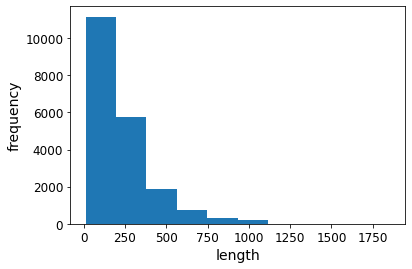

In [57]:
import matplotlib.pyplot as plt

plt.hist(lengths)
plt.xlabel('length')
plt.ylabel('frequency')
plt.show()

### 리뷰의 길이 맞추기

In [58]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

train_seq = pad_sequences(train_input, maxlen=100)
print(train_seq.shape)

(20000, 100)


In [59]:
print(train_seq[0])

[ 10   4  20   9   2 364 352   5  45   6   2   2  33 269   8   2 142   2
   5   2  17  73  17 204   5   2  19  55   2   2  92  66 104  14  20  93
  76   2 151  33   4  58  12 188   2 151  12 215  69 224 142  73 237   6
   2   7   2   2 188   2 103  14  31  10  10 451   7   2   5   2  80  91
   2  30   2  34  14  20 151  50  26 131  49   2  84  46  50  37  80  79
   6   2  46   7  14  20  10  10 470 158]


In [60]:
print(train_input[0][-10:])

[6, 2, 46, 7, 14, 20, 10, 10, 470, 158]


In [61]:
print(train_seq[5])

[  0   0   0   0   1   2 195  19  49   2   2 190   4   2 352   2 183  10
  10  13  82  79   4   2  36  71 269   8   2  25  19  49   7   4   2   2
   2   2   2  10  10  48  25  40   2  11   2   2  40   2   2   5   4   2
   2  95  14 238  56 129   2  10  10  21   2  94 364 352   2   2  11 190
  24 484   2   7  94 205 405  10  10  87   2  34  49   2   7   2   2   2
   2   2 290   2  46  48  64  18   4   2]


In [62]:
val_seq = pad_sequences(val_input, maxlen=100)

### 신경망 만들기

In [63]:
from tensorflow import keras

model = keras.Sequential()

model.add(keras.layers.SimpleRNN(8, input_shape=(100, 500)))
model.add(keras.layers.Dense(1, activation='sigmoid'))

In [64]:
#원핫인코딩
train_oh = keras.utils.to_categorical(train_seq)
print(train_oh.shape)

(20000, 100, 500)


In [65]:
#처음 12개의 원소만 출력
print(train_oh[0][0][:12])
#원소의 합을 구해서 나머지가 0인지 확인
print(np.sum(train_oh[0][0]))

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
1.0


In [66]:
#검증 데이터도 원핫 인코딩
val_oh = keras.utils.to_categorical(val_seq)

In [67]:
#모델 구조 확인
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_12 (SimpleRNN)    (None, 8)                 4072      
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 9         
Total params: 4,081
Trainable params: 4,081
Non-trainable params: 0
_________________________________________________________________


### 신경망 훈련

In [68]:
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model.compile(optimizer=rmsprop, loss='binary_crossentropy', 
              metrics=['accuracy'])

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-simplernn-model.h5')
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3,
                                                  restore_best_weights=True)

history = model.fit(train_oh, train_target, epochs=100, batch_size=64,
                    validation_data=(val_oh, val_target),
                    callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 [==============================] - 13s 40ms/step - loss: 0.6944 - accuracy: 0.4981 - val_loss: 0.6931 - val_accuracy: 0.4982
Epoch 2/100
313/313 [==============================] - 11s 35ms/step - loss: 0.6929 - accuracy: 0.5116 - val_loss: 0.6925 - val_accuracy: 0.5108
Epoch 3/100
313/313 [==============================] - 10s 33ms/step - loss: 0.6919 - accuracy: 0.5202 - val_loss: 0.6920 - val_accuracy: 0.5196
Epoch 4/100
313/313 [==============================] - 10s 31ms/step - loss: 0.6909 - accuracy: 0.5258 - val_loss: 0.6914 - val_accuracy: 0.5238
Epoch 5/100
313/313 [==============================] - 10s 32ms/step - loss: 0.6899 - accuracy: 0.5340 - val_loss: 0.6909 - val_accuracy: 0.5318
Epoch 6/100
313/313 [==============================] - 9s 30ms/step - loss: 0.6888 - accuracy: 0.5392 - val_loss: 0.6905 - val_accuracy: 0.5344
Epoch 7/100
313/313 [==============================] - 10s 32ms/step - loss: 0.6877 - accuracy: 0.5459 - val_loss: 0.6900 - val_acc

### 손실 그래프

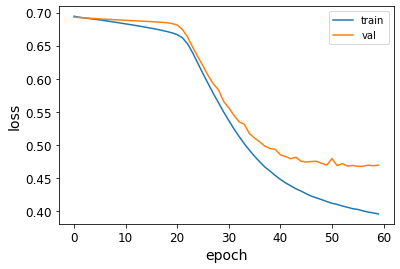

In [69]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

### 단어 임베딩 사용하기

In [70]:
model2 = keras.Sequential()

model2.add(keras.layers.Embedding(500, 16, input_length=100))
model2.add(keras.layers.SimpleRNN(8))
model2.add(keras.layers.Dense(1, activation='sigmoid'))

model2.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 100, 16)           8000      
_________________________________________________________________
simple_rnn_13 (SimpleRNN)    (None, 8)                 200       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 9         
Total params: 8,209
Trainable params: 8,209
Non-trainable params: 0
_________________________________________________________________


In [71]:
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model2.compile(optimizer=rmsprop, loss='binary_crossentropy', 
               metrics=['accuracy'])

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-embedding-model.h5')
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3,
                                                  restore_best_weights=True)

history = model2.fit(train_seq, train_target, epochs=100, batch_size=64,
                     validation_data=(val_seq, val_target),
                     callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 [==============================] - 6s 16ms/step - loss: 0.6946 - accuracy: 0.4963 - val_loss: 0.6930 - val_accuracy: 0.5084
Epoch 2/100
313/313 [==============================] - 5s 15ms/step - loss: 0.6920 - accuracy: 0.5187 - val_loss: 0.6916 - val_accuracy: 0.5276
Epoch 3/100
313/313 [==============================] - 5s 15ms/step - loss: 0.6900 - accuracy: 0.5393 - val_loss: 0.6905 - val_accuracy: 0.5362
Epoch 4/100
313/313 [==============================] - 5s 14ms/step - loss: 0.6875 - accuracy: 0.5541 - val_loss: 0.6902 - val_accuracy: 0.5298
Epoch 5/100
313/313 [==============================] - 4s 14ms/step - loss: 0.6847 - accuracy: 0.5658 - val_loss: 0.6897 - val_accuracy: 0.5350
Epoch 6/100
313/313 [==============================] - 5s 15ms/step - loss: 0.6817 - accuracy: 0.5731 - val_loss: 0.6889 - val_accuracy: 0.5352
Epoch 7/100
313/313 [==============================] - 4s 14ms/step - loss: 0.6779 - accuracy: 0.5849 - val_loss: 0.6860 - val_accuracy:

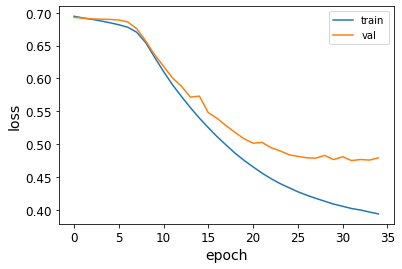

In [72]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

## IMDB 감성 분석을 LSTM을 이용하기

### 데이터 가져오기

In [73]:
from tensorflow.keras.datasets import imdb
from sklearn.model_selection import train_test_split

(train_input, train_target), (test_input, test_target) = imdb.load_data(
    num_words=500)

train_input, val_input, train_target, val_target = train_test_split(
    train_input, train_target, test_size=0.2, random_state=42)

### 데이터 길이 맞추기

In [74]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

train_seq = pad_sequences(train_input, maxlen=100)
val_seq = pad_sequences(val_input, maxlen=100)

### 모델 만들기

In [75]:
from tensorflow import keras

model = keras.Sequential()

model.add(keras.layers.Embedding(500, 16, input_length=100))
model.add(keras.layers.LSTM(8))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 100, 16)           8000      
_________________________________________________________________
lstm_5 (LSTM)                (None, 8)                 800       
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 9         
Total params: 8,809
Trainable params: 8,809
Non-trainable params: 0
_________________________________________________________________


### 모델 훈련

In [76]:
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model.compile(optimizer=rmsprop, loss='binary_crossentropy', 
              metrics=['accuracy'])

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-lstm-model.h5')
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3,
                                                  restore_best_weights=True)

history = model.fit(train_seq, train_target, epochs=100, batch_size=64,
                    validation_data=(val_seq, val_target),
                    callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 [==============================] - 11s 27ms/step - loss: 0.6923 - accuracy: 0.5401 - val_loss: 0.6913 - val_accuracy: 0.5592
Epoch 2/100
313/313 [==============================] - 8s 25ms/step - loss: 0.6891 - accuracy: 0.6115 - val_loss: 0.6868 - val_accuracy: 0.6246
Epoch 3/100
313/313 [==============================] - 8s 24ms/step - loss: 0.6806 - accuracy: 0.6444 - val_loss: 0.6716 - val_accuracy: 0.6540
Epoch 4/100
313/313 [==============================] - 8s 24ms/step - loss: 0.6366 - accuracy: 0.6690 - val_loss: 0.5989 - val_accuracy: 0.7272
Epoch 5/100
313/313 [==============================] - 8s 25ms/step - loss: 0.5769 - accuracy: 0.7485 - val_loss: 0.5667 - val_accuracy: 0.7432
Epoch 6/100
313/313 [==============================] - 8s 24ms/step - loss: 0.5512 - accuracy: 0.7576 - val_loss: 0.5515 - val_accuracy: 0.7350
Epoch 7/100
313/313 [==============================] - 8s 27ms/step - loss: 0.5304 - accuracy: 0.7660 - val_loss: 0.5342 - val_accuracy

### 손실 시각화

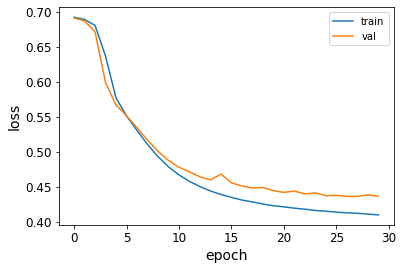

In [77]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

### 드롭 아웃 적용

In [78]:
model2 = keras.Sequential()

model2.add(keras.layers.Embedding(500, 16, input_length=100))
model2.add(keras.layers.LSTM(8, dropout=0.3))
model2.add(keras.layers.Dense(1, activation='sigmoid'))

In [79]:
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model2.compile(optimizer=rmsprop, loss='binary_crossentropy', 
               metrics=['accuracy'])

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-dropout-model.h5')
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3,
                                                  restore_best_weights=True)

history = model2.fit(train_seq, train_target, epochs=100, batch_size=64,
                     validation_data=(val_seq, val_target),
                     callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 [==============================] - 9s 25ms/step - loss: 0.6922 - accuracy: 0.5418 - val_loss: 0.6914 - val_accuracy: 0.5880
Epoch 2/100
313/313 [==============================] - 8s 25ms/step - loss: 0.6897 - accuracy: 0.6048 - val_loss: 0.6882 - val_accuracy: 0.6396
Epoch 3/100
313/313 [==============================] - 8s 24ms/step - loss: 0.6837 - accuracy: 0.6535 - val_loss: 0.6785 - val_accuracy: 0.6736
Epoch 4/100
313/313 [==============================] - 7s 24ms/step - loss: 0.6562 - accuracy: 0.6939 - val_loss: 0.6251 - val_accuracy: 0.7044
Epoch 5/100
313/313 [==============================] - 7s 24ms/step - loss: 0.6031 - accuracy: 0.7207 - val_loss: 0.5902 - val_accuracy: 0.7352
Epoch 6/100
313/313 [==============================] - 7s 24ms/step - loss: 0.5809 - accuracy: 0.7321 - val_loss: 0.5704 - val_accuracy: 0.7412
Epoch 7/100
313/313 [==============================] - 13s 41ms/step - loss: 0.5618 - accuracy: 0.7459 - val_loss: 0.5522 - val_accuracy

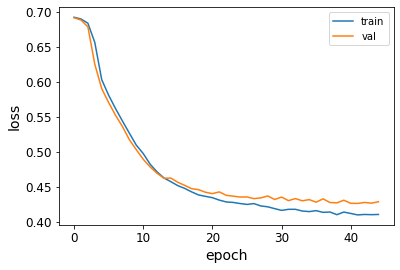

In [80]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

### 2개의 층 연결하기

In [81]:
model3 = keras.Sequential()

model3.add(keras.layers.Embedding(500, 16, input_length=100))
model3.add(keras.layers.LSTM(8, dropout=0.3, return_sequences=True))
model3.add(keras.layers.LSTM(8, dropout=0.3))
model3.add(keras.layers.Dense(1, activation='sigmoid'))

model3.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 100, 16)           8000      
_________________________________________________________________
lstm_7 (LSTM)                (None, 100, 8)            800       
_________________________________________________________________
lstm_8 (LSTM)                (None, 8)                 544       
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 9         
Total params: 9,353
Trainable params: 9,353
Non-trainable params: 0
_________________________________________________________________


In [82]:
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model3.compile(optimizer=rmsprop, loss='binary_crossentropy', 
               metrics=['accuracy'])

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-2rnn-model.h5')
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3,
                                                  restore_best_weights=True)

history = model3.fit(train_seq, train_target, epochs=100, batch_size=64,
                     validation_data=(val_seq, val_target),
                     callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 [==============================] - 20s 54ms/step - loss: 0.6926 - accuracy: 0.5336 - val_loss: 0.6916 - val_accuracy: 0.5926
Epoch 2/100
313/313 [==============================] - 16s 52ms/step - loss: 0.6898 - accuracy: 0.5964 - val_loss: 0.6864 - val_accuracy: 0.6358
Epoch 3/100
313/313 [==============================] - 18s 59ms/step - loss: 0.6747 - accuracy: 0.6431 - val_loss: 0.6519 - val_accuracy: 0.6748
Epoch 4/100
313/313 [==============================] - 17s 53ms/step - loss: 0.5980 - accuracy: 0.6905 - val_loss: 0.5576 - val_accuracy: 0.7108
Epoch 5/100
313/313 [==============================] - 15s 48ms/step - loss: 0.5372 - accuracy: 0.7361 - val_loss: 0.5113 - val_accuracy: 0.7546
Epoch 6/100
313/313 [==============================] - 15s 49ms/step - loss: 0.5101 - accuracy: 0.7541 - val_loss: 0.4918 - val_accuracy: 0.7670
Epoch 7/100
313/313 [==============================] - 15s 48ms/step - loss: 0.4888 - accuracy: 0.7667 - val_loss: 0.4774 - val_ac

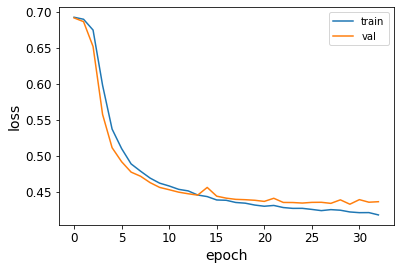

In [83]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

## 한국어 감성 분석

### import

In [30]:
# 필요 라이브러리 불러오기
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

import warnings
warnings.filterwarnings(action='ignore')

In [31]:
# Naver sentiment movie corpus 데이터 불러오기
train_file = tf.keras.utils.get_file(
    '.ratings_train.txt', origin='http://cyberadam.cafe24.com/movieimage/ratings_train.txt', extract=True)

train = pd.read_csv(train_file, sep='\t')

### EDA(탐색적 데이터 분석)

In [32]:
print(train.shape)

(150000, 3)


In [33]:
# 레이블별 개수
cnt = train['label'].value_counts()
print(cnt)

0    75173
1    74827
Name: label, dtype: int64


<AxesSubplot:xlabel='label', ylabel='count'>

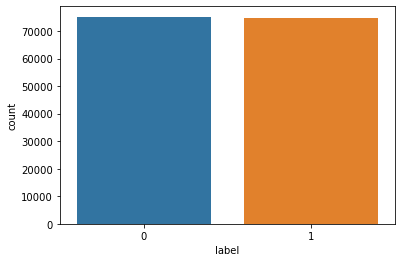

In [34]:
# 레이블별 비율 
sns.countplot(x='label',data=train)

In [35]:
# 결측치 확인
train.isnull().sum()  

id          0
document    5
label       0
dtype: int64

In [36]:
# 결측치(의견없음)가 특정 label값만 있는지 확인
train[train['document'].isnull()]

,id,document,label
25857,2172111,NaN,1
55737,6369843,NaN,1
110014,1034280,NaN,0
126782,5942978,NaN,0
140721,1034283,NaN,0


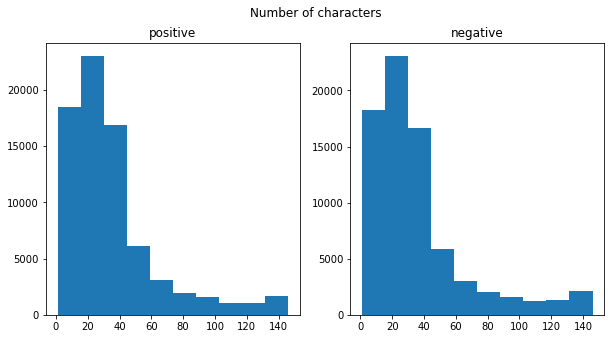

In [37]:
# 레이블 별 텍스트 길이
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
data_len=train[train['label']==1]['document'].str.len()
ax1.hist(data_len)
ax1.set_title('positive')

data_len=train[train['label']==0]['document'].str.len()
ax2.hist(data_len)
ax2.set_title('negative')
fig.suptitle('Number of characters')
plt.show()

### 형태소 분석기 설치

In [ ]:
#Mac에서는 터미널에서 아래 명령어 실행 - jdk 를 먼저 설치 해야 함
bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)

pip install --upgrade pip
pip install JPype1-0.5.7-cp27-none-win_amd64.whl
pip install konlpy

In [ ]:
# Mecab 형태소 설치 - 코랩에서의 설치
%%bash
apt-get update
apt-get install g++ openjdk-8-jdk python3-dev python3-pip curl


%env JAVA_HOME "/usr/lib/jvm/java-8-openjdk-amd64"

%%bash
pip3 install JPype1
pip3 install konlpy
apt-get install curl git
bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)
pip3 install /tmp/mecab-python-0.996

In [ ]:
#Windows 에서는 Mecab 지원 안함 
#jdk 를 설치 한 후 JAVA_HOME 환경변수에 jdk 경로를 설정해야 함
pip install --upgrade pip
pip install JPype1-0.5.7-cp27-none-win_amd64.whl
pip install konlpy

### 형태소 분석기 가져오기

In [95]:
# Kkma, Komoran, Okt, Mecab 형태소
import konlpy
from konlpy.tag import Kkma, Komoran, Okt, Mecab

kkma = Kkma()
komoran = Komoran()
okt = Okt()
mecab = Mecab()

### 형태소 분석

In [96]:
# 형태소별 샘플
text = "시리야안녕오늘날씨어때?"

def sample_ko_pos(text):
    print(f"==== {text} ====")
    print("kkma:",kkma.pos(text))
    print("komoran:",komoran.pos(text))
    print("okt:",okt.pos(text))
    print("mecab:",mecab.pos(text))
    print("\n")

sample_ko_pos(text)

==== 시리야안녕오늘날씨어때? ====
kkma: [('시', 'NNG'), ('리', 'NNG'), ('야', 'JX'), ('안녕', 'NNG'), ('오늘날', 'NNG'), ('씨', 'NNB'), ('어', 'VV'), ('어', 'ECS'), ('때', 'NNG'), ('?', 'SF')]
komoran: [('시', 'NNB'), ('리야', 'NNP'), ('안녕', 'NNP'), ('오늘날', 'NNP'), ('씨', 'NNB'), ('어떻', 'VA'), ('어', 'EF'), ('?', 'SF')]
okt: [('시리', 'Noun'), ('야', 'Josa'), ('안녕', 'Noun'), ('오늘날', 'Noun'), ('씨', 'Suffix'), ('어때', 'Adjective'), ('?', 'Punctuation')]
mecab: [('시리', 'VA'), ('야', 'EF'), ('안녕', 'IC'), ('오늘', 'MAG'), ('날씨', 'NNG'), ('어때', 'VA+EF'), ('?', 'SF')]




In [97]:
text2 = "시리야안뇽오늘날씨어때?"
sample_ko_pos(text2)

==== 시리야안뇽오늘날씨어때? ====
kkma: [('시', 'NNG'), ('리', 'XSN'), ('야', 'JX'), ('안', 'MAG'), ('뇽', 'UN'), ('오늘날', 'NNG'), ('씨', 'NNB'), ('어', 'VV'), ('어', 'ECS'), ('때', 'NNG'), ('?', 'SF')]
komoran: [('시리야안뇽오늘날씨어때?', 'NA')]
okt: [('시리', 'Noun'), ('야', 'Josa'), ('안뇽', 'Noun'), ('오늘날', 'Noun'), ('씨', 'Suffix'), ('어때', 'Adjective'), ('?', 'Punctuation')]
mecab: [('시리', 'NNG'), ('야안', 'NNG'), ('뇽오늘날씨어때', 'UNKNOWN'), ('?', 'SF')]




In [98]:
text3 = "정말 재미있고 매력적인 영화에요 추천합니다."
sample_ko_pos(text3)

==== 정말 재미있고 매력적인 영화에요 추천합니다. ====
kkma: [('정말', 'MAG'), ('재미있', 'VA'), ('고', 'ECE'), ('매력적', 'NNG'), ('이', 'VCP'), ('ㄴ', 'ETD'), ('영화', 'NNG'), ('에', 'JKM'), ('요', 'JX'), ('추천', 'NNG'), ('하', 'XSV'), ('ㅂ니다', 'EFN'), ('.', 'SF')]
komoran: [('정말', 'MAG'), ('재미있', 'VA'), ('고', 'EC'), ('매력', 'NNG'), ('적', 'XSN'), ('이', 'VCP'), ('ㄴ', 'ETM'), ('영화', 'NNG'), ('에', 'JKB'), ('요', 'JX'), ('추천', 'NNG'), ('하', 'XSV'), ('ㅂ니다', 'EF'), ('.', 'SF')]
okt: [('정말', 'Noun'), ('재미있고', 'Adjective'), ('매력', 'Noun'), ('적', 'Suffix'), ('인', 'Josa'), ('영화', 'Noun'), ('에요', 'Josa'), ('추천', 'Noun'), ('합니다', 'Verb'), ('.', 'Punctuation')]
mecab: [('정말', 'MAG'), ('재미있', 'VA'), ('고', 'EC'), ('매력', 'NNG'), ('적', 'XSN'), ('인', 'VCP+ETM'), ('영화', 'NNG'), ('에', 'JKB'), ('요', 'MM'), ('추천', 'NNG'), ('합니다', 'XSV+EF'), ('.', 'SF')]




### 데이터 전처리

In [99]:
# 텍스트 전처리(영어와 한글만 남기고 삭제)
train['document'] = train['document'].str.replace("[^A-Za-z가-힣ㄱ-ㅎㅏ-ㅣ ]","")
train['document'].head()

0                                    아 더빙 진짜 짜증나네요 목소리
1                           흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나
2                                    너무재밓었다그래서보는것을추천한다
3                            교도소 이야기구먼 솔직히 재미는 없다평점 조정
4    사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...
Name: document, dtype: object

In [100]:
# 결측치 제거
train = train.dropna()
train.shape

(149995, 3)

In [101]:
# 스탑워드와 형태소 분석
stop_words = ["는", "을", "를", '이', '가', '의', '던', '고', '하', '다', '은', '에', '들', '지', '게', '도'] # 한글 불용어
def word_tokenization(text):
  return [word for word in mecab.morphs(text) if word not in stop_words]

In [102]:
data = train['document'].apply((lambda x: word_tokenization(x)))
data.head()

0                        [아, 더, 빙, 진짜, 짜증, 나, 네요, 목소리]
1       [흠, 포스터, 보고, 초딩, 영화, 줄, 오버, 연기, 조차, 가볍, 않, 구나]
2                              [너무, 재, 밓었다그래서보는것을추천한다]
3                   [교도소, 이야기, 구먼, 솔직히, 재미, 없, 평점, 조정]
4    [사이몬페그, 익살, 스런, 연기, 돋보였, 영화, 스파이더맨, 에서, 늙, 어, ...
Name: document, dtype: object

In [103]:
# train과 validation 분할
training_size = 120000

# train 분할
train_sentences = data[:training_size]
valid_sentences = data[training_size:]

# label 분할
train_labels = train['label'][:training_size]
valid_labels = train['label'][training_size:]

In [104]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# vocab_size 설정
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data)
print("총 단어 갯수 : ",len(tokenizer.word_index))

# 5회 이상만 vocab_size에 포함
def get_vocab_size(threshold):
  cnt = 0
  for x in tokenizer.word_counts.values():
    if x >= threshold:
      cnt = cnt + 1
  return cnt

vocab_size = get_vocab_size(5) # 5회 이상 출현 단어
print("vocab_size: ", vocab_size)

총 단어 갯수 :  52171
vocab_size:  15568


In [105]:
oov_tok = "<OOV>" # 사전에 없는 단어
vocab_size = 15000

tokenizer = Tokenizer(oov_token=oov_tok, num_words=vocab_size)
tokenizer.fit_on_texts(data)
print("단어 사전 개수:", len(tokenizer.word_counts))

단어 사전 개수: 52171


In [106]:
# 문자를 숫자로 표현
print(train_sentences[:2])
train_sequences = tokenizer.texts_to_sequences(train_sentences)
valid_sequences = tokenizer.texts_to_sequences(valid_sentences)
print(train_sequences[:2])

0                     [아, 더, 빙, 진짜, 짜증, 나, 네요, 목소리]
1    [흠, 포스터, 보고, 초딩, 영화, 줄, 오버, 연기, 조차, 가볍, 않, 구나]
Name: document, dtype: object
[[22, 63, 913, 27, 214, 8, 23, 706], [975, 486, 495, 638, 2, 107, 1572, 43, 878, 960, 33, 363]]


In [107]:
# 문장의 최대 길이
max_length = max(len(x) for x in train_sequences)
print("문장 최대 길이:", max_length)

문장 최대 길이: 74


In [108]:
# 문장 길이를 동일하게 맞춘다
trunc_type='post'
padding_type='post'

train_padded = pad_sequences(train_sequences, truncating=trunc_type, padding=padding_type, maxlen=max_length)
valid_padded = pad_sequences(valid_sequences, truncating=trunc_type, padding=padding_type, maxlen=max_length)

train_labels = np.asarray(train_labels)
valid_labels = np.asarray(valid_labels)

print("샘플:", train_padded[:1])

샘플: [[ 22  63 913  27 214   8  23 706   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0]]


### 모델 생성

In [109]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, Bidirectional

def create_model():
    model = Sequential([
                Embedding(vocab_size, 32),
                Bidirectional(LSTM(32, return_sequences=True)),    
                Dense(32, activation='relu'),
                Dense(1, activation='sigmoid')
    ])
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

model = create_model()
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 32)          480000    
_________________________________________________________________
bidirectional_3 (Bidirection (None, None, 64)          16640     
_________________________________________________________________
dense_8 (Dense)              (None, None, 32)          2080      
_________________________________________________________________
dense_9 (Dense)              (None, None, 1)           33        
Total params: 498,753
Trainable params: 498,753
Non-trainable params: 0
_________________________________________________________________


In [110]:
# 가장 좋은 loss의 가중치 저장
checkpoint_path = 'best_performed_model.ckpt'
checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, 
                                                save_weights_only=True, 
                                                save_best_only=True, 
                                                monitor='val_loss',
                                                verbose=1)
# 학습조기종료
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)

# 학습
history = model.fit(train_padded, train_labels, 
                validation_data=(valid_padded, valid_labels), 
                callbacks=[early_stop, checkpoint], batch_size=64, epochs=10, verbose=2)

Epoch 1/10
1875/1875 - 74s - loss: 0.4025 - accuracy: 0.8146 - val_loss: 0.3606 - val_accuracy: 0.8444

Epoch 00001: val_loss improved from inf to 0.36055, saving model to best_performed_model.ckpt
Epoch 2/10
1875/1875 - 63s - loss: 0.3136 - accuracy: 0.8655 - val_loss: 0.3369 - val_accuracy: 0.8544

Epoch 00002: val_loss improved from 0.36055 to 0.33687, saving model to best_performed_model.ckpt
Epoch 3/10
1875/1875 - 49s - loss: 0.2725 - accuracy: 0.8841 - val_loss: 0.3548 - val_accuracy: 0.8455

Epoch 00003: val_loss did not improve from 0.33687
Epoch 4/10
1875/1875 - 50s - loss: 0.2429 - accuracy: 0.8985 - val_loss: 0.3446 - val_accuracy: 0.8524

Epoch 00004: val_loss did not improve from 0.33687


### 평가

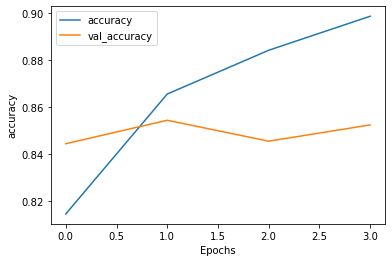

In [111]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()
plot_graphs(history, 'accuracy')

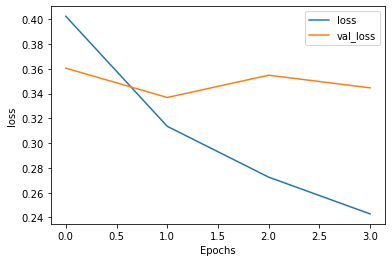

In [112]:
plot_graphs(history, 'loss')

### 테스트 데이터에 적용

In [113]:
# 테스트 데이터 불러오기
test_file = tf.keras.utils.get_file(
    'ratings_test.txt', origin='http:/cyberadam.cafe24.com/ratings_test.txt', extract=True)

test = pd.read_csv(test_file, sep='\t')
test.head()

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


In [124]:
# 데이터 전처리
def preprocessing(df):
  df['document'] = df['document'].str.replace("[^A-Za-z가-힣ㄱ-ㅎㅏ-ㅣ ]","")
  df = df.dropna()
  test_label = np.asarray(df['label'])
  test_data =  df['document'].apply((lambda x: word_tokenization(x)))
  test_data = tokenizer.texts_to_sequences(test_data)
  test_data = pad_sequences(test_data, truncating=trunc_type, padding=padding_type, maxlen=max_length)
  return test_data, test_label

test_data, test_label = preprocessing(test)
print(model.evaluate(test_data, test_label))

<class 'pandas.core.frame.DataFrame'>
1563/1563 [==============================] - 9s 6ms/step - loss: 0.3507 - accuracy: 0.8486
[0.35073569416999817, 0.848627507686615]


In [115]:
# 기본 모델 로드 후 평가
model2 = create_model()
model2.evaluate(test_data, test_label)

1563/1563 [==============================] - 12s 7ms/step - loss: 0.6931 - accuracy: 0.5031


[0.6931324601173401, 0.503121018409729]

In [116]:
# 저장된 가중치 적용된 모델 로드 후 평가
model2.load_weights(checkpoint_path)
model2.evaluate(test_data, test_label)

1563/1563 [==============================] - 10s 7ms/step - loss: 0.3423 - accuracy: 0.8518


[0.3423337936401367, 0.8517836928367615]

In [159]:
def sentiment_predict(new_sentence):
    sample_data = pd.Series([new_sentence.replace("[^A-Za-z가-힣ㄱ-ㅎㅏ-ㅣ ]","")])
    sample_data =  sample_data.apply((lambda x: word_tokenization(x)))
    sample_data = tokenizer.texts_to_sequences(sample_data)
    score = model2.predict(sample_data) # 예측

    score = float(score[0][0][0])
    if(score > 0.5):
        print("{:.2f}% 확률로 긍정 리뷰입니다.\n".format(score * 100))
    else:
        print("{:.2f}% 확률로 부정 리뷰입니다.\n".format((1 - score) * 100))

sentiment_predict('도대체 감독은 무슨 생각에 영화를 만들었을까?')        
sentiment_predict('와 정말 재미있는 세계관 최강자들의 영화다')

87.96% 확률로 부정 리뷰입니다.

80.15% 확률로 긍정 리뷰입니다.



### KoBERT 토크나이저

In [60]:
!git clone https://github.com/SKTBrain/KoBERT.git

fatal: destination path 'KoBERT' already exists and is not an empty directory.


In [61]:
cd KoBERT

/Users/adam/Documents/lecture/PYTHON/6.DeepLearning/KoBERT


In [62]:
pip install -r requirements.txt

  Using cached torch-1.9.0-cp38-none-macosx_10_9_x86_64.whl (127.9 MB)
  Attempting uninstall: torch
    Found existing installation: torch 1.4.0
    Uninstalling torch-1.4.0:
      Successfully uninstalled torch-1.4.0
Note: you may need to restart the kernel to use updated packages.


In [63]:
from gluonnlp.data import SentencepieceTokenizer
from kobert.utils import get_tokenizer
tok_path = get_tokenizer()
sp  = SentencepieceTokenizer(tok_path)
print(sp('시리야오늘날씨어때?'))
print(sp('시리야 오늘 날씨 어때?'))

using cached model
['▁시', '리', '야', '오늘', '날', '씨', '어', '때', '?']
['▁시', '리', '야', '▁오늘', '▁날씨', '▁어', '때', '?']


In [79]:
# 위와 동일한 전처리 과정
def word_tokenization_kobert(text):
    return [word for word in sp(text) if word not in stop_words]

def train_preprocessing(df):
    df['document'] = df['document'].str.replace("[^A-Za-z가-힣ㄱ-ㅎㅏ-ㅣ ]","")
    df = df.dropna()
    data =  df['document'].apply((lambda x: word_tokenization_kobert(x)))
    #print(data.head())
    data = tokenizer.texts_to_sequences(data)
    data = pad_sequences(data, truncating=trunc_type, padding=padding_type, maxlen=max_length)

    training_size = 120000
    train_sentences = data[:training_size]
    valid_sentences = data[training_size:]
    train_labels = np.asarray(df['label'][:training_size])
    valid_labels = np.asarray(df['label'][training_size:])
    return train_sentences, valid_sentences, train_labels, valid_labels

train_padded, valid_padded, train_labels, valid_labels = train_preprocessing(train)

(120000, 74)


In [65]:
#기본 모델을 생성해서 훈련
model3 = create_model()
history3 = model3.fit(train_padded, train_labels, 
                validation_data=(valid_padded, valid_labels), 
                callbacks=[early_stop, checkpoint], batch_size=64, epochs=10, verbose=2)

Epoch 1/10
1875/1875 - 61s - loss: 0.5624 - accuracy: 0.6990 - val_loss: 0.5336 - val_accuracy: 0.7272

Epoch 00001: val_loss did not improve from 0.33664
Epoch 2/10
1875/1875 - 47s - loss: 0.5269 - accuracy: 0.7273 - val_loss: 0.5227 - val_accuracy: 0.7334

Epoch 00002: val_loss did not improve from 0.33664
Epoch 3/10
1875/1875 - 50s - loss: 0.5135 - accuracy: 0.7351 - val_loss: 0.5176 - val_accuracy: 0.7325

Epoch 00003: val_loss did not improve from 0.33664
Epoch 4/10
1875/1875 - 60s - loss: 0.5020 - accuracy: 0.7434 - val_loss: 0.5180 - val_accuracy: 0.7377

Epoch 00004: val_loss did not improve from 0.33664
Epoch 5/10
1875/1875 - 54s - loss: 0.4932 - accuracy: 0.7496 - val_loss: 0.5240 - val_accuracy: 0.7351

Epoch 00005: val_loss did not improve from 0.33664


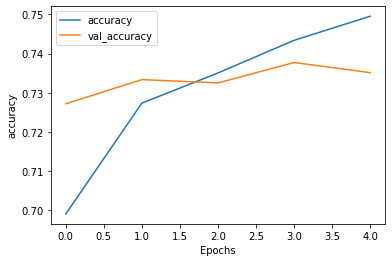

In [66]:
plot_graphs(history3, 'accuracy')

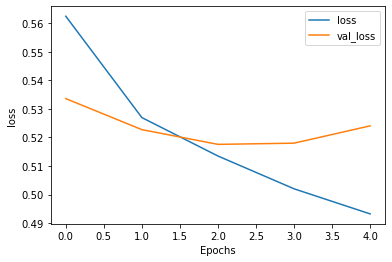

In [67]:
plot_graphs(history3, 'loss')

## 로이터 뉴스 기사 분류

### import

In [2]:
from tensorflow.keras.datasets import reuters
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

### 데이터 가져오기

In [3]:
(X_train, y_train), (X_test, y_test) = reuters.load_data(num_words=None, test_split=0.2)

print('훈련용 뉴스 기사 : {}'.format(len(X_train)))
print('테스트용 뉴스 기사 : {}'.format(len(X_test)))
num_classes = max(y_train) + 1
print('카테고리 : {}'.format(num_classes))

2113536/2110848 [==============================] - 1s 1us/step
훈련용 뉴스 기사 : 8982
테스트용 뉴스 기사 : 2246
카테고리 : 46


In [4]:
print(X_train[0]) # 첫번째 훈련용 뉴스 기사
print(y_train[0]) # 첫번째 훈련용 뉴스 기사의 레이블

[1, 27595, 28842, 8, 43, 10, 447, 5, 25, 207, 270, 5, 3095, 111, 16, 369, 186, 90, 67, 7, 89, 5, 19, 102, 6, 19, 124, 15, 90, 67, 84, 22, 482, 26, 7, 48, 4, 49, 8, 864, 39, 209, 154, 6, 151, 6, 83, 11, 15, 22, 155, 11, 15, 7, 48, 9, 4579, 1005, 504, 6, 258, 6, 272, 11, 15, 22, 134, 44, 11, 15, 16, 8, 197, 1245, 90, 67, 52, 29, 209, 30, 32, 132, 6, 109, 15, 17, 12]
3


### 각 기사의 길이 확인

뉴스 기사의 최대 길이 :2376
뉴스 기사의 평균 길이 :145.5398574927633


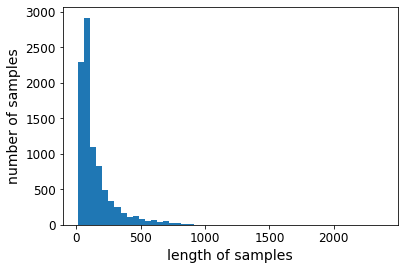

In [5]:
print('뉴스 기사의 최대 길이 :{}'.format(max(len(l) for l in X_train)))
print('뉴스 기사의 평균 길이 :{}'.format(sum(map(len, X_train))/len(X_train)))

plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

### 레이블의 분포 확인

<AxesSubplot:ylabel='count'>

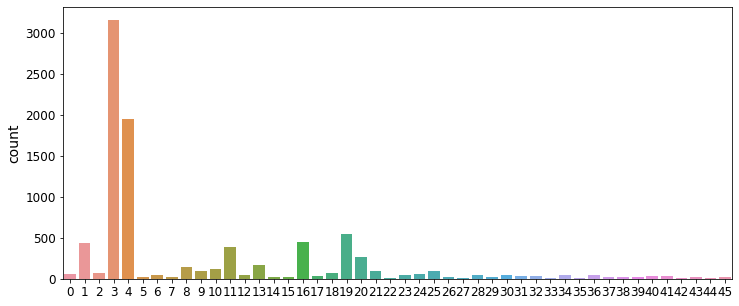

In [6]:
fig, axe = plt.subplots(ncols=1)
fig.set_size_inches(12,5)
sns.countplot(y_train)

In [7]:
unique_elements, counts_elements = np.unique(y_train, return_counts=True)
print("각 레이블에 대한 빈도수:")
print(np.asarray((unique_elements, counts_elements)))
# label_cnt=dict(zip(unique_elements, counts_elements))
# 아래의 출력 결과가 보기 불편하여 병렬로 보고싶다면 위의 label_cnt를 출력

각 레이블에 대한 빈도수:
[[   0    1    2    3    4    5    6    7    8    9   10   11   12   13
    14   15   16   17   18   19   20   21   22   23   24   25   26   27
    28   29   30   31   32   33   34   35   36   37   38   39   40   41
    42   43   44   45]
 [  55  432   74 3159 1949   17   48   16  139  101  124  390   49  172
    26   20  444   39   66  549  269  100   15   41   62   92   24   15
    48   19   45   39   32   11   50   10   49   19   19   24   36   30
    13   21   12   18]]


### 단어 확인

In [8]:
word_to_index = reuters.get_word_index()
print(word_to_index)

557056/550378 [==============================] - 2s 3us/step
{'mdbl': 10996, 'fawc': 16260, 'degussa': 12089, 'woods': 8803, 'hanging': 13796, 'localized': 20672, 'sation': 20673, 'chanthaburi': 20675, 'refunding': 10997, 'hermann': 8804, 'passsengers': 20676, 'stipulate': 20677, 'heublein': 8352, 'screaming': 20713, 'tcby': 16261, 'four': 185, 'grains': 1642, 'broiler': 20680, 'wooden': 12090, 'wednesday': 1220, 'highveld': 13797, 'duffour': 7593, '0053': 20681, 'elections': 3914, '270': 2563, '271': 3551, '272': 5113, '273': 3552, '274': 3400, 'rudman': 7975, '276': 3401, '277': 3478, '278': 3632, '279': 4309, 'dormancy': 9381, 'errors': 7247, 'deferred': 3086, 'sptnd': 20683, 'cooking': 8805, 'stratabit': 20684, 'designing': 16262, 'metalurgicos': 20685, 'databank': 13798, '300er': 20686, 'shocks': 20687, 'nawg': 7972, 'tnta': 20688, 'perforations': 20689, 'affiliates': 2891, '27p': 20690, 'ching': 16263, 'china': 595, 'wagyu': 16264, 'affiliated': 3189, 'chino': 16265, 'chinh': 162

In [9]:
index_to_word = {}
for key, value in word_to_index.items():
    index_to_word[value] = key
    
print('빈도수 상위 28842번 단어 : {}'.format(index_to_word[28842]))
print('빈도수 상위 1번 단어 : {}'.format(index_to_word[1]))

빈도수 상위 28842번 단어 : nondiscriminatory
빈도수 상위 1번 단어 : the


In [11]:
for index, token in enumerate(("<pad>", "<sos>", "<unk>")):
  index_to_word[index]=token

print(' '.join([index_to_word[index] for index in X_train[0]]))

<sos> wattie nondiscriminatory mln loss for plc said at only ended said commonwealth could 1 traders now april 0 a after said from 1985 and from foreign 000 april 0 prices its account year a but in this mln home an states earlier and rise and revs vs 000 its 16 vs 000 a but 3 psbr oils several and shareholders and dividend vs 000 its all 4 vs 000 1 mln agreed largely april 0 are 2 states will billion total and against 000 pct dlrs


### 모델 생성 및 훈련을 위한 import

In [12]:
from tensorflow.keras.datasets import reuters
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

### 데이터 전처리

In [13]:
(X_train, y_train), (X_test, y_test) = reuters.load_data(num_words=1000, test_split=0.2)

max_len = 100
X_train = pad_sequences(X_train, maxlen=max_len) # 훈련용 뉴스 기사 패딩
X_test = pad_sequences(X_test, maxlen=max_len) # 테스트용 뉴스 기사 패딩

y_train = to_categorical(y_train) # 훈련용 뉴스 기사 레이블의 원-핫 인코딩
y_test = to_categorical(y_test) # 테스트용 뉴스 기사 레이블의 원-핫 인코딩

### 모델 생성 및 훈련

In [14]:
model = Sequential()
model.add(Embedding(1000, 120))
model.add(LSTM(120))
model.add(Dense(46, activation='softmax'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

history = model.fit(X_train, y_train, batch_size=128, epochs=30, callbacks=[es, mc], validation_data=(X_test, y_test))

2021-07-25 20:34:08.463056: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-07-25 20:34:08.795957: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30
71/71 [==============================] - 15s 183ms/step - loss: 2.5951 - acc: 0.3447 - val_loss: 2.3974 - val_acc: 0.3620

Epoch 00001: val_acc improved from -inf to 0.36198, saving model to best_model.h5
Epoch 2/30
71/71 [==============================] - 13s 184ms/step - loss: 2.1024 - acc: 0.4610 - val_loss: 1.9058 - val_acc: 0.5191

Epoch 00002: val_acc improved from 0.36198 to 0.51915, saving model to best_model.h5
Epoch 3/30
71/71 [==============================] - 13s 177ms/step - loss: 1.7931 - acc: 0.5433 - val_loss: 1.7667 - val_acc: 0.5263

Epoch 00003: val_acc improved from 0.51915 to 0.52627, saving model to best_model.h5
Epoch 4/30
71/71 [==============================] - 13s 187ms/step - loss: 1.7051 - acc: 0.5550 - val_loss: 1.8022 - val_acc: 0.5378

Epoch 00004: val_acc improved from 0.52627 to 0.53785, saving model to best_model.h5
Epoch 5/30
71/71 [==============================] - 13s 184ms/step - loss: 1.6508 - acc: 0.5748 - val_loss: 1.6614 - val_acc: 0

### 정확도 확인

In [15]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

71/71 [==============================] - 1s 14ms/step - loss: 1.1948 - acc: 0.7297

 테스트 정확도: 0.7297


### 손실 확인

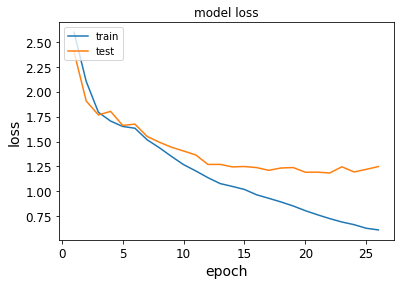

In [16]:
epochs = range(1, len(history.history['acc']) + 1)
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## LSTM을 이용한 주가 예측

### 라이브러리 import

In [41]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, Activation
from pandas.io.parsers import read_csv

In [ ]:
# colab 사용자는 파일을 파일 업로드 수행
from google.colab import files
uploaded = files.upload()

### 데이터 읽어오기

In [31]:
data = pd.read_csv('./data/kakao.csv')
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2000-02-11,54600.0,54600.0,54600.0,54600.0,51524.144531,276500.0
1,2000-02-14,52800.0,59600.0,48100.0,49400.0,46617.078125,6270500.0
2,2000-02-15,50000.0,51800.0,43500.0,43500.0,41049.457031,3243000.0
3,2000-02-16,42000.0,48700.0,40000.0,48700.0,45956.519531,4357000.0
4,2000-02-17,49200.0,53500.0,47000.0,48700.0,45956.519531,5099000.0


### 전처리

In [33]:
#결측치 제거
data = data.dropna(axis=0)

In [35]:
#가장 높은 가격 과 낮은 가격의 중간값을 생성
high_price = data['High'].values
low_price = data['Low'].values
mid_price = (high_price + low_price) / 2

In [36]:
#데이터들을 첫날부터 50일씩 끊어서 저장
#[ [0~50일], [1~51일], [2~52일], [3~53일]....... ]
# 50일 치 데이터를 가지고 51일째 되는 날의 주가를 예측하기 위해서

day_divided = 50
day_length = day_divided + 1
day_result = []
for i in range(len(mid_price) - day_length):
    day_result.append(mid_price[i: i + day_length])

In [37]:
#분리된 데이터 확인
print("전체 데이터 Length : ", len(data))
print("나눈 데이터 Length : ", len(day_result))
print("나눈 데이터 0번째 : ")
print(day_result[0])
print(day_result[1])

전체 데이터 Length :  5385
나눈 데이터 Length :  5334
나눈 데이터 0번째 : 
[54600. 53850. 47650. 44350. 50250. 48150. 42950. 41300. 36550. 39150.
 41950. 38850. 37350. 36800. 36800. 32300. 30950. 29400. 31400. 33400.
 36500. 33600. 29600. 28800. 29700. 27450. 23900. 21800. 23600. 22900.
 22100. 22450. 23350. 21600. 20600. 22400. 19920. 17910. 17560. 18380.
 19190. 21750. 21650. 19400. 19400. 17740. 15040. 14910. 14100. 12830.
 13170.]
[53850. 47650. 44350. 50250. 48150. 42950. 41300. 36550. 39150. 41950.
 38850. 37350. 36800. 36800. 32300. 30950. 29400. 31400. 33400. 36500.
 33600. 29600. 28800. 29700. 27450. 23900. 21800. 23600. 22900. 22100.
 22450. 23350. 21600. 20600. 22400. 19920. 17910. 17560. 18380. 19190.
 21750. 21650. 19400. 19400. 17740. 15040. 14910. 14100. 12830. 13170.
 13380.]


In [38]:
#50일씩 나누었던 데이터들을 첫날 기준으로 정규화 진행
#첫날을 0으로 만들고, 나머지 날들은 그 비율로 나누어 정규화

norm_result = []
for section in day_result:
    norm_section = [((float(p) / float(section[0])) - 1) for p in section]
    norm_result.append(norm_section)
day_result = np.array(norm_result)

print(day_result[0])

[ 0.         -0.01373626 -0.12728938 -0.18772894 -0.07967033 -0.11813187
 -0.21336996 -0.24358974 -0.33058608 -0.28296703 -0.23168498 -0.28846154
 -0.31593407 -0.32600733 -0.32600733 -0.40842491 -0.43315018 -0.46153846
 -0.42490842 -0.38827839 -0.33150183 -0.38461538 -0.45787546 -0.47252747
 -0.45604396 -0.49725275 -0.56227106 -0.6007326  -0.56776557 -0.58058608
 -0.5952381  -0.58882784 -0.57234432 -0.6043956  -0.62271062 -0.58974359
 -0.63516484 -0.67197802 -0.67838828 -0.66336996 -0.6485348  -0.60164835
 -0.60347985 -0.64468864 -0.64468864 -0.67509158 -0.72454212 -0.72692308
 -0.74175824 -0.76501832 -0.75879121]


### 훈련 데이터 와 검증 데이터 만들기

In [39]:
train_data_rate = 0.9
boundary = round(day_result.shape[0] * train_data_rate)
train_data = day_result[:boundary, :]
test_data = day_result[boundary:, :]

x_train = train_data[:, :-1]
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = train_data[:, -1]

x_test = test_data[:, :-1]
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
y_test = test_data[:, -1]

x_train.shape, x_test.shape

((4801, 50, 1), (533, 50, 1))

### 모델 생성 및 구조 확인

In [42]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(50, 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(1, activation='relu'))
model.compile(loss='mse', optimizer='sgd')

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50, 50)            10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                29440     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 39,905
Trainable params: 39,905
Non-trainable params: 0
_________________________________________________________________


### 모델 훈련

In [15]:
model.fit(x_train, y_train,
    validation_data=(x_test, y_test),
    batch_size=10,
    epochs=15)

2021-07-22 10:03:03.523512: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/15
481/481 [==============================] - 14s 23ms/step - loss: 0.0299 - val_loss: 0.0105
Epoch 2/15
481/481 [==============================] - 11s 23ms/step - loss: 0.0242 - val_loss: 0.0068
Epoch 3/15
481/481 [==============================] - 10s 21ms/step - loss: 0.0239 - val_loss: 0.0069
Epoch 4/15
481/481 [==============================] - 10s 21ms/step - loss: 0.0237 - val_loss: 0.0068
Epoch 5/15
481/481 [==============================] - 10s 22ms/step - loss: 0.0236 - val_loss: 0.0058
Epoch 6/15
481/481 [==============================] - 10s 22ms/step - loss: 0.0235 - val_loss: 0.0063
Epoch 7/15
481/481 [==============================] - 10s 21ms/step - loss: 0.0234 - val_loss: 0.0055
Epoch 8/15
481/481 [==============================] - 11s 22ms/step - loss: 0.0233 - val_loss: 0.0057
Epoch 9/15
481/481 [==============================] - 15s 30ms/step - loss: 0.0232 - val_loss: 0.0054
Epoch 10/15
481/481 [==============================] - 11s 22ms/step - loss: 0.023

### 결과 예측 및 시각화

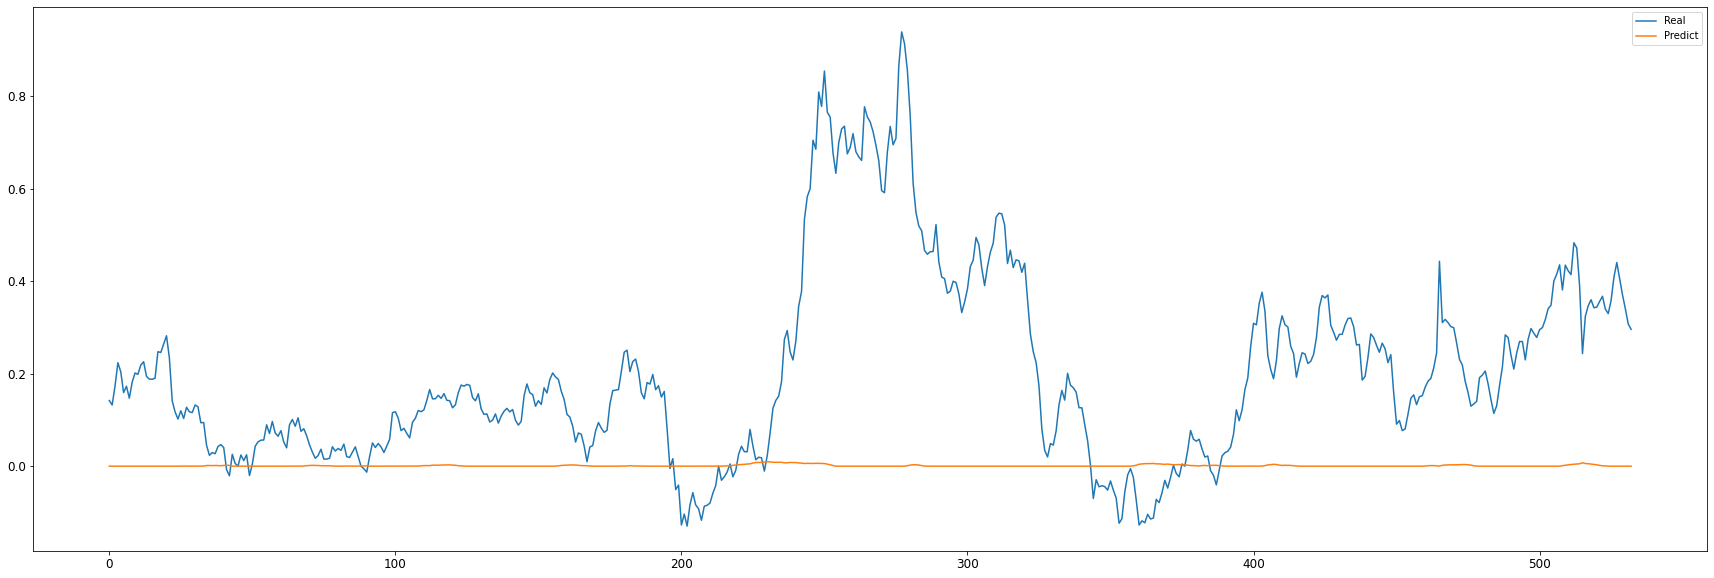

In [45]:
pred = model.predict(x_test)

import matplotlib.pyplot as plt

plot_figure = plt.figure(figsize=(30, 10))
plot_rst = plot_figure.add_subplot(111)
plot_rst.plot(y_test, label='Real')
plot_rst.plot(pred, label='Predict')
plot_rst.legend()
plt.show()

## GRU

### 데이터 가져오기

In [17]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split

(train_input, train_target), (test_input, test_target) = imdb.load_data(
    num_words=500)

train_input, val_input, train_target, val_target = train_test_split(
    train_input, train_target, test_size=0.2, random_state=42)

train_seq = pad_sequences(train_input, maxlen=100)
val_seq = pad_sequences(val_input, maxlen=100)

### 신경망 훈련

In [18]:
model4 = keras.Sequential()

model4.add(keras.layers.Embedding(500, 16, input_length=100))
model4.add(keras.layers.GRU(8))
model4.add(keras.layers.Dense(1, activation='sigmoid'))

model4.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 16)           8000      
_________________________________________________________________
gru (GRU)                    (None, 8)                 624       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 8,633
Trainable params: 8,633
Non-trainable params: 0
_________________________________________________________________


In [19]:
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model4.compile(optimizer=rmsprop, loss='binary_crossentropy', 
               metrics=['accuracy'])

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-gru-model.h5')
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=3,
                                                  restore_best_weights=True)

history = model4.fit(train_seq, train_target, epochs=100, batch_size=64,
                     validation_data=(val_seq, val_target),
                     callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 [==============================] - 10s 28ms/step - loss: 0.6926 - accuracy: 0.5207 - val_loss: 0.6916 - val_accuracy: 0.5444
Epoch 2/100
313/313 [==============================] - 9s 27ms/step - loss: 0.6902 - accuracy: 0.5695 - val_loss: 0.6890 - val_accuracy: 0.5742
Epoch 3/100
313/313 [==============================] - 9s 28ms/step - loss: 0.6862 - accuracy: 0.5990 - val_loss: 0.6845 - val_accuracy: 0.5992
Epoch 4/100
313/313 [==============================] - 9s 29ms/step - loss: 0.6796 - accuracy: 0.6187 - val_loss: 0.6766 - val_accuracy: 0.6124
Epoch 5/100
313/313 [==============================] - 9s 28ms/step - loss: 0.6683 - accuracy: 0.6334 - val_loss: 0.6634 - val_accuracy: 0.6358
Epoch 6/100
313/313 [==============================] - 9s 28ms/step - loss: 0.6484 - accuracy: 0.6583 - val_loss: 0.6390 - val_accuracy: 0.6612
Epoch 7/100
313/313 [==============================] - 9s 28ms/step - loss: 0.6072 - accuracy: 0.6895 - val_loss: 0.5827 - val_accuracy

### 손실 그래프

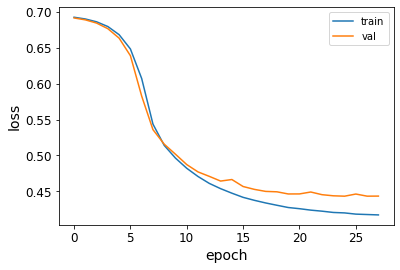

In [20]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

### 이전 모델을 호출해서 평가

In [21]:
test_seq = pad_sequences(test_input, maxlen=100)

rnn_model = keras.models.load_model('best-gru-model.h5')
# 텐서플로 2.3에서는 버그(https://github.com/tensorflow/tensorflow/issues/42890) 때문에 compile() 메서드를 호출해야 합니다.
# rnn_model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics='accuracy')

rnn_model.evaluate(test_seq, test_target)

782/782 [==============================] - 4s 4ms/step - loss: 0.4373 - accuracy: 0.7984


[0.43732911348342896, 0.7983999848365784]

## 네이버 쇼핑 리뷰 감성 분류 - GRU 활용

### import

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from collections import Counter
from konlpy.tag import Mecab
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

### 데이터 가져오기

In [25]:
urllib.request.urlretrieve("http://cyberadam.cafe24.com/movieimage/ratings_total.txt", filename="./data/ratings_total.txt")

('./data/ratings_total.txt', <http.client.HTTPMessage at 0x7fcddd848ac0>)

In [26]:
total_data = pd.read_table('./data/ratings_total.txt', names=['ratings', 'reviews'])
print('전체 리뷰 개수 :',len(total_data)) # 전체 리뷰 개수 출력

전체 리뷰 개수 : 200000


In [27]:
total_data[:5]

,ratings,reviews
0,5,배공빠르고 굿
1,2,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고
2,5,아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...
3,2,선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전...
4,5,민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ


### label 생성

In [28]:
total_data['label'] = np.select([total_data.ratings > 3], [1], default=0)
total_data[:5]

,ratings,reviews,label
0,5,배공빠르고 굿,1
1,2,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고,0
2,5,아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...,1
3,2,선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전...,0
4,5,민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ,1


### 중복을 제거한 리뷰 수 확인

In [29]:
total_data['ratings'].nunique(), total_data['reviews'].nunique(), total_data['label'].nunique()

(4, 199908, 2)

### 중복 제거

In [30]:
total_data.drop_duplicates(subset=['reviews'], inplace=True) # reviews 열에서 중복인 내용이 있다면 중복 제거
print('총 샘플의 수 :',len(total_data))

총 샘플의 수 : 199908


### 훈련 데이터 와 테스트 데이터 분류

In [31]:
print(total_data.isnull().values.any())

False


In [32]:
train_data, test_data = train_test_split(total_data, test_size = 0.25, random_state = 42)
print('훈련용 리뷰의 개수 :', len(train_data))
print('테스트용 리뷰의 개수 :', len(test_data))

훈련용 리뷰의 개수 : 149931
테스트용 리뷰의 개수 : 49977


### 레이블 분포 확인

<AxesSubplot:>

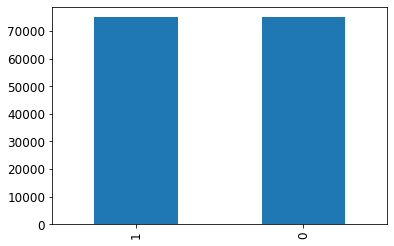

In [33]:
train_data['label'].value_counts().plot(kind = 'bar')

In [34]:
print(train_data.groupby('label').size().reset_index(name = 'count'))

   label  count
0      0  74918
1      1  75013


### 데이터 정제

In [35]:
# 한글과 공백을 제외하고 모두 제거
train_data['reviews'] = train_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_data['reviews'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())

ratings    0
reviews    0
label      0
dtype: int64


In [36]:
test_data.drop_duplicates(subset = ['reviews'], inplace=True) # 중복 제거
test_data['reviews'] = test_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
test_data['reviews'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

전처리 후 테스트용 샘플의 개수 : 49977


### 토큰화

In [38]:
mecab = Mecab()
print(mecab.morphs('와 이런 것도 상품이라고 차라리 내가 만드는 게 나을 뻔'))

['와', '이런', '것', '도', '상품', '이', '라고', '차라리', '내', '가', '만드', '는', '게', '나을', '뻔']


In [39]:
stopwords = ['도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게']

train_data['tokenized'] = train_data['reviews'].apply(mecab.morphs)
train_data['tokenized'] = train_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

test_data['tokenized'] = test_data['reviews'].apply(mecab.morphs)
test_data['tokenized'] = test_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

### 레이블에 따른 단어의 빈도수 계산

In [41]:
negative_words = np.hstack(train_data[train_data.label == 0]['tokenized'].values)
positive_words = np.hstack(train_data[train_data.label == 1]['tokenized'].values)

In [42]:
negative_word_count = Counter(negative_words)
print(negative_word_count.most_common(20))

[('네요', 31799), ('는데', 20295), ('안', 19718), ('어요', 14849), ('있', 13200), ('너무', 13058), ('했', 11783), ('좋', 9812), ('배송', 9677), ('같', 8997), ('구매', 8876), ('어', 8869), ('거', 8854), ('없', 8670), ('아요', 8642), ('습니다', 8436), ('그냥', 8355), ('되', 8345), ('잘', 8029), ('않', 7984)]


In [43]:
positive_word_count = Counter(positive_words)
print(positive_word_count.most_common(20))

[('좋', 39488), ('아요', 21184), ('네요', 19895), ('어요', 18686), ('잘', 18602), ('구매', 16171), ('습니다', 13320), ('있', 12391), ('배송', 12275), ('는데', 11670), ('했', 9818), ('합니다', 9801), ('먹', 9635), ('재', 9273), ('너무', 8397), ('같', 7868), ('만족', 7261), ('거', 6482), ('어', 6294), ('쓰', 6292)]


### 단어의 평균 길이

긍정 리뷰의 평균 길이 : 13.5877381253916
부정 리뷰의 평균 길이 : 17.029498918817907


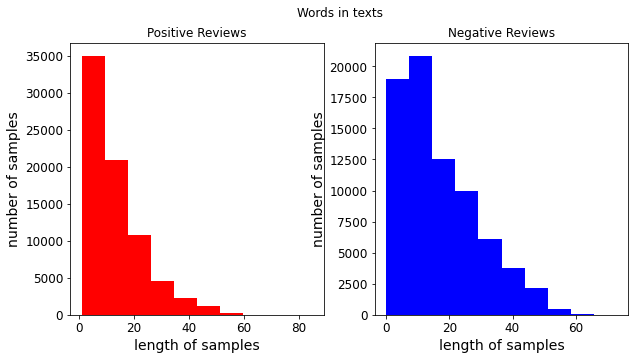

In [44]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
text_len = train_data[train_data['label']==1]['tokenized'].map(lambda x: len(x))
ax1.hist(text_len, color='red')
ax1.set_title('Positive Reviews')
ax1.set_xlabel('length of samples')
ax1.set_ylabel('number of samples')
print('긍정 리뷰의 평균 길이 :', np.mean(text_len))

text_len = train_data[train_data['label']==0]['tokenized'].map(lambda x: len(x))
ax2.hist(text_len, color='blue')
ax2.set_title('Negative Reviews')
fig.suptitle('Words in texts')
ax2.set_xlabel('length of samples')
ax2.set_ylabel('number of samples')
print('부정 리뷰의 평균 길이 :', np.mean(text_len))
plt.show()

### 테스트 데이터 와 훈련 데이터 생성

In [46]:
X_train = train_data['tokenized'].values
y_train = train_data['label'].values
X_test= test_data['tokenized'].values
y_test = test_data['label'].values

### 정수 인코딩

In [47]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [48]:
threshold = 2
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 39997
등장 빈도가 1번 이하인 희귀 단어의 수: 18212
단어 집합에서 희귀 단어의 비율: 45.53341500612546
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 0.7935259575621343


### 1번만 등장한 단어 제외

In [49]:
# 전체 단어 개수 중 빈도수 2이하인 단어 개수는 제거.
# 0번 패딩 토큰과 1번 OOV 토큰을 고려하여 +2
vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 21787


### 없는 단어는 OOV로 설정하고 정수화

In [50]:
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV') 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [51]:
print(X_train[:3])

[[67, 2060, 299, 14260, 263, 73, 6, 236, 168, 137, 805, 2951, 625, 2, 77, 62, 207, 40, 1343, 155, 3, 6], [482, 409, 52, 8530, 2561, 2517, 339, 2918, 250, 2357, 38, 473, 2], [46, 24, 825, 105, 35, 2372, 160, 7, 10, 8061, 4, 1319, 29, 140, 322, 41, 59, 160, 140, 7, 1916, 2, 113, 162, 1379, 323, 119, 136]]


In [52]:
print(X_test[:3])

[[14, 704, 767, 116, 186, 252, 12], [339, 3904, 62, 3816, 1651], [11, 69, 2, 49, 164, 3, 27, 15, 6, 513, 289, 17, 92, 110, 564, 59, 7, 2]]


### 패딩

리뷰의 최대 길이 : 85
리뷰의 평균 길이 : 15.307528129606286


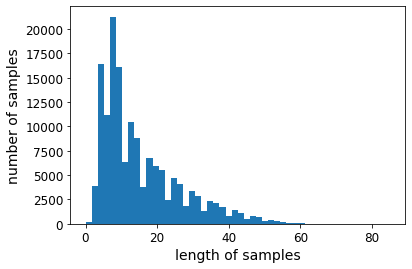

In [53]:
print('리뷰의 최대 길이 :',max(len(l) for l in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [54]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

In [55]:
max_len = 80
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 80 이하인 샘플의 비율: 99.99933302652553


In [56]:
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

### 모델 생성 과 훈련

In [57]:
from tensorflow.keras.layers import Embedding, Dense, GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [58]:
model = Sequential()
model.add(Embedding(vocab_size, 100))
model.add(GRU(128))
model.add(Dense(1, activation='sigmoid'))

In [59]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=60, validation_split=0.2)

Epoch 1/15
2000/2000 [==============================] - 139s 68ms/step - loss: 0.2683 - acc: 0.8989 - val_loss: 0.2245 - val_acc: 0.9182

Epoch 00001: val_acc improved from -inf to 0.91820, saving model to best_model.h5
Epoch 2/15
2000/2000 [==============================] - 129s 65ms/step - loss: 0.2144 - acc: 0.9228 - val_loss: 0.2136 - val_acc: 0.9242

Epoch 00002: val_acc improved from 0.91820 to 0.92423, saving model to best_model.h5
Epoch 3/15
2000/2000 [==============================] - 120s 60ms/step - loss: 0.1981 - acc: 0.9288 - val_loss: 0.2125 - val_acc: 0.9224

Epoch 00003: val_acc did not improve from 0.92423
Epoch 4/15
2000/2000 [==============================] - 120s 60ms/step - loss: 0.1874 - acc: 0.9334 - val_loss: 0.2040 - val_acc: 0.9272

Epoch 00004: val_acc improved from 0.92423 to 0.92717, saving model to best_model.h5
Epoch 5/15
2000/2000 [==============================] - 119s 59ms/step - loss: 0.1785 - acc: 0.9372 - val_loss: 0.2039 - val_acc: 0.9278

Epoch 00

In [60]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

1562/1562 [==============================] - 14s 9ms/step - loss: 0.2108 - acc: 0.9248

 테스트 정확도: 0.9248


### 리뷰 예측

In [61]:
def sentiment_predict(new_sentence):
  new_sentence = mecab.morphs(new_sentence) # 토큰화
  new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
  encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
  score = float(loaded_model.predict(pad_new)) # 예측
  if(score > 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다.".format(score * 100))
  else:
    print("{:.2f}% 확률로 부정 리뷰입니다.".format((1 - score) * 100))

In [62]:
sentiment_predict('이 상품 진짜 좋아요... 저는 강추합니다. 대박')
sentiment_predict('진짜 배송도 늦고 짜증나네요. 뭐 이런 걸 상품이라고 만듬?')
sentiment_predict('판매자님... 너무 짱이에요.. 대박나삼')
sentiment_predict('ㅁㄴㅇㄻㄴㅇㄻㄴㅇ리뷰쓰기도 귀찮아요')

99.03% 확률로 긍정 리뷰입니다.
99.36% 확률로 부정 리뷰입니다.
98.31% 확률로 긍정 리뷰입니다.
95.07% 확률로 부정 리뷰입니다.


## 마르코프 체인

In [66]:
import codecs
from bs4 import BeautifulSoup
from konlpy.tag import Twitter
import urllib.request
import os, re, json, random

# 마르코프 체인 딕셔너리 만들기
def make_dic(words):
    tmp = ["@"]
    dic = {}
    for word in words:
        tmp.append(word)
        if len(tmp) < 3: continue
        if len(tmp) > 3: tmp = tmp[1:]
        set_word3(dic, tmp)
        if word == ".":
            tmp = ["@"]
            continue
    return dic

# 딕셔너리에 데이터 등록하기
def set_word3(dic, s3):
    w1, w2, w3 = s3
    if not w1 in dic: dic[w1] = {}
    if not w2 in dic[w1]: dic[w1][w2] = {}
    if not w3 in dic[w1][w2]: dic[w1][w2][w3] = 0
    dic[w1][w2][w3] += 1

# 문장 읽어 들이기
dict_file = "./data/markov-toji.json"

if not os.path.exists(dict_file):
    # 토지 텍스트 파일 읽어 들이기
    fp = codecs.open("./data/BEXX0003.txt", "r", encoding="utf-16")
    soup = BeautifulSoup(fp, "html.parser")
    body = soup.select_one("body > text")
    text = body.getText()
    text = text.replace("…", "") # 현재 koNLPy가 …을 구두점으로 잡지 못하는 문제 임시 해결
    # 형태소 분석
    twitter = Twitter()
    malist = twitter.pos(text, norm=True)
    words = []
    for word in malist:
        # 구두점 등은 대상에서 제외(단 마침표는 포함)
        if not word[1] in ["Punctuation"]:
            words.append(word[0])
        if word[0] == ".":
            words.append(word[0])
    # 딕셔너리 생성
    dic = make_dic(words)
    json.dump(dic, open(dict_file,"w", encoding="utf-8"))
else:
    dic = json.load(open(dict_file,"r"))
    
print(dic['걱정'])

{'이며': {'이윽고': 1}, '마라': {'\n': 3, '.': 3}, '은': {'마라': 2, '안': 1}, '할': {'것': 1}, '말고': {'마저': 1, '처': 1}, '들': {'을': 1}, '을': {'다': 1}, '이': {'있고': 1, '있더라고': 1, '없을': 1, '요': 1}, '말': {'게': 1}, '일세': {'.': 1}, '하실': {'것': 1}, '이고': {'송장': 1, '\n': 1}, '이제': {'.': 1}, '이다': {'그': 1}}


## LSTM을 이용한 자연어 생성

### 기본 라이브러리

In [67]:
# 기본 라이브러리
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

### 데이터 가져오기

In [69]:
# 네이버 영화리뷰 데이터셋 불러오기
file = tf.keras.utils.get_file(
    'ratings_train.txt', 
    origin='http://cyberadam.cafe24.com/movieimage/ratings_train.txt', 
    extract=True)

df = pd.read_csv(file, sep='\t')

14630912/14628807 [==============================] - 1s 0us/step


In [70]:
# 데이터 임의샘플 확인
df[1000:1007]

,id,document,label
1000,9856453,정말 최고의 명작 성인이 되고 본 이집트의 왕자는 또 다른 감동 그자체네요,1
1001,6961803,이영화만 성공 했어도 스퀘어가 에닉스랑 합병 할일은 없었을텐데..,0
1002,8681713,울컥하는 사회현실 ㅠㅠ,1
1003,5348290,기대를하나도안하면 할일없을때보기좋은영화,0
1004,9340549,소림사 관문 통과하기 진짜 어렵다는거 보여준 영화..극장에서 개봉하는거 반갑다..,1
1005,7357684,시리즈안나오나 ㅠㅠㅠㅠㅠㅠㅠㅠ,1
1006,9303587,끝난다는 사실이 너무 슬퍼요. 가슴이 뻥 뚫려버린것같아..,1


### 데이터 전처리

In [72]:
# 형태소 분석기 
#!pip install konlpy

from konlpy.tag import Okt
okt = Okt()

# 데이터 전처리
def word_tokenization(text):
  return [word for word in okt.morphs(text)]

def preprocessing(df):
  df = df.dropna()
  df = df[1000:2000]  # 샘플 데이터 1000개, 학습시간을 줄이고자 함 
  df['document'] = df['document'].str.replace("[^A-Za-z0-9가-힣ㄱ-ㅎㅏ-ㅣ ]","")
  data =  df['document'].apply((lambda x: word_tokenization(x)))
  return data

In [73]:
# 텍스트 데이터 1000개 전처리 후 불러오기
review = preprocessing(df)
len(review)

1000

In [74]:
# 형태소 분리된 데이터 확인
print(review[:10])

1000    [정말, 최고, 의, 명작, 성인, 이, 되고, 본, 이집트, 의, 왕자, 는, 또...
1001    [이영화, 만, 성공, 했어도, 스퀘어, 가, 에, 닉스, 랑, 합병, 할, 일, ...
1002                                 [울컥, 하는, 사회, 현실, ㅠㅠ]
1003       [기대, 를, 하나, 도안, 하, 면, 할, 일, 없을, 때, 보기, 좋은, 영화]
1004    [소림사, 관문, 통과, 하기, 진짜, 어렵다는거, 보여준, 영화, 극장, 에서, ...
1005                              [시리즈, 안, 나오나, ㅠㅠㅠㅠㅠㅠㅠㅠ]
1006        [끝난다는, 사실, 이, 너무, 슬퍼요, 가슴, 이, 뻥, 뚫려, 버린것, 같아]
1007                                             [펑점, 조절]
1008                            [와이, 건, 진짜, 으리, 으리, 한, 데]
1009                                [손발, 이, 오, 그라드, 네, 요]
Name: document, dtype: object


In [76]:
# 토큰화 및 패딩
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
tokenizer = Tokenizer()

def get_tokens(review):
  tokenizer.fit_on_texts(review)
  total_words = len(tokenizer.word_index)+1
  tokenized_sentences = tokenizer.texts_to_sequences(review)

  input_sequences = []
  for token in tokenized_sentences:
    for t in range(1, len(token)):
        n_gram_sequence = token[:t+1]
        input_sequences.append(n_gram_sequence)

  return input_sequences, total_words

input_sequences, total_words = get_tokens(review)
input_sequences[31:40] # n_gram으로 리스트된 데이터샘플 확인

[[792, 25],
 [792, 25, 539],
 [792, 25, 539, 140],
 [792, 25, 539, 140, 109],
 [338, 9],
 [338, 9, 110],
 [338, 9, 110, 540],
 [338, 9, 110, 540, 90],
 [338, 9, 110, 540, 90, 148]]

In [77]:
# 단어 사전
print("감동 ==>> ",tokenizer.word_index['감동'])
print("영화 ==>> ",tokenizer.word_index['영화'])
print("코믹 ==>> ",tokenizer.word_index['코믹'])

감동 ==>>  46
영화 ==>>  2
코믹 ==>>  415


In [78]:
# 문장의 길이 동일하게 맞추기
max_len = max([len(word) for word in input_sequences])
print("max_len:", max_len)
input_sequences = np.array(pad_sequences(input_sequences, 
                                         maxlen=max_len, 
                                         padding='pre'))

max_len: 59


In [80]:
# 입력텍스트와 타겟
from tensorflow.keras.utils import to_categorical
X = input_sequences[:,:-1]  # 마지막 값은 제외함
y = to_categorical(input_sequences[:,-1], 
                   num_classes=total_words) # 마지막 값만 이진 클래스 벡터로 변환

# y를 설명하기 위한 예시
a = to_categorical([0, 1, 2, 3], num_classes=4)
a

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]], dtype=float32)

### 모델 생성 과 훈련

In [81]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout

embedding_dim = 256

model = Sequential([
    Embedding(input_dim=total_words, 
              output_dim=embedding_dim, 
              input_length=max_len-1), 
    Bidirectional(LSTM(units=256)),
    Dense(units=total_words, activation='softmax'),
])
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])
history = model.fit(X, y, epochs=20, verbose=1)

Epoch 1/20
375/375 [==============================] - 70s 180ms/step - loss: 7.7425 - accuracy: 0.0249
Epoch 2/20
375/375 [==============================] - 65s 172ms/step - loss: 7.1693 - accuracy: 0.0316
Epoch 3/20
375/375 [==============================] - 63s 168ms/step - loss: 6.7977 - accuracy: 0.0420
Epoch 4/20
375/375 [==============================] - 72s 191ms/step - loss: 6.1970 - accuracy: 0.0643
Epoch 5/20
375/375 [==============================] - 65s 173ms/step - loss: 5.3417 - accuracy: 0.0999
Epoch 6/20
375/375 [==============================] - 64s 171ms/step - loss: 4.3777 - accuracy: 0.1807
Epoch 7/20
375/375 [==============================] - 67s 178ms/step - loss: 3.4243 - accuracy: 0.3336
Epoch 8/20
375/375 [==============================] - 68s 180ms/step - loss: 2.5895 - accuracy: 0.4972
Epoch 9/20
375/375 [==============================] - 64s 172ms/step - loss: 1.9119 - accuracy: 0.6419
Epoch 10/20
375/375 [==============================] - 62s 165ms/step - l

### 문장 생성(추론)

In [82]:
# 문장생성함수 (시작 텍스트, 생성 단어 개수)
def text_generation(sos, count):
    for _ in range(1, count):
        token_list = tokenizer.texts_to_sequences([sos])[0]
        token_list = pad_sequences([token_list], 
                                   maxlen=max_len-1, 
                                   padding='pre')
        predicted = np.argmax(model.predict(token_list), axis=1) # 최대값 인덱스

        for word, idx in tokenizer.word_index.items():
            if idx == predicted:
                output = word
                break
        sos += " " + output
    return sos

In [83]:
# argmax 설명: 최대값의 인덱스 반환
data = [[0.1, 0.2, 0.7], [0.3, 0.5, 0.2], [0.4, 0.3, 0.3]]
np.argmax([data], axis=-1)

array([[2, 1, 0]])

In [84]:
text_generation("연애 하면서", 12)

'연애 하면서 바랬어 요 ㅎㅎ 개 나 랑 동시 상 열으 루 봤는데'

In [85]:
text_generation("꿀잼", 12)

'꿀잼 근데 아나킨 은 언제 이유 가 있구나 진짜 멋 지드 라'

In [86]:
text_generation("최고의 영화", 12)

'최고의 영화 보다 나간 적은 처음 ㅠㅠ ㅠㅠ 최고 의 드라마 외국 드라마'

In [87]:
text_generation("손발 이", 12)

'손발 이 오 그라드 네 요 요 공포 내용 이 평점 이 필요없다'

## Seq2Seq 모델로 챗봇 구현하기

### 라이브러리 설치

In [1]:
#Korpora 라이브러리 설치
!pip install Korpora

### 라이브러리 불러오기

In [2]:
from Korpora import KoreanChatbotKorpus
corpus = KoreanChatbotKorpus()


    Korpora 는 다른 분들이 연구 목적으로 공유해주신 말뭉치들을
    손쉽게 다운로드, 사용할 수 있는 기능만을 제공합니다.

    말뭉치들을 공유해 주신 분들에게 감사드리며, 각 말뭉치 별 설명과 라이센스를 공유 드립니다.
    해당 말뭉치에 대해 자세히 알고 싶으신 분은 아래의 description 을 참고,
    해당 말뭉치를 연구/상용의 목적으로 이용하실 때에는 아래의 라이센스를 참고해 주시기 바랍니다.

    # Description
    Author : songys@github
    Repository : https://github.com/songys/Chatbot_data
    References :

    Chatbot_data_for_Korean v1.0
      1. 챗봇 트레이닝용 문답 페어 11,876개
      2. 일상다반사 0, 이별(부정) 1, 사랑(긍정) 2로 레이블링
    자세한 내용은 위의 repository를 참고하세요.

    # License
    CC0 1.0 Universal (CC0 1.0) Public Domain Dedication
    Details in https://creativecommons.org/publicdomain/zero/1.0/

[Korpora] Corpus `korean_chatbot_data` is already installed at /Users/adam/Korpora/korean_chatbot_data/ChatbotData.csv


### 챗봇 데이터 샘플 확인

In [3]:
print(corpus.get_all_texts()[:5])
print(corpus.get_all_pairs()[:5])

['12시 땡!', '1지망 학교 떨어졌어', '3박4일 놀러가고 싶다', '3박4일 정도 놀러가고 싶다', 'PPL 심하네']
('하루가 또 가네요.', '위로해 드립니다.', '여행은 언제나 좋죠.', '여행은 언제나 좋죠.', '눈살이 찌푸려지죠.')


### 하나의 문장 확인

In [4]:
# text와 pair가 쌍으로 이루어짐
print("Q:", corpus.train[0].text)
print("A:", corpus.train[0].pair)

Q: 12시 땡!
A: 하루가 또 가네요.


### 전체 데이터 개수 확인

In [5]:
# 전체 코퍼스 크기 (11,823개)
len(corpus.get_all_texts())

11823

### 데이터를 메모리로 가져오기

In [6]:
# 2,000개 데이터 셋만 활용 (Google Colab 일 경우 3,000개에서는 메모리 오버되는 현상 발생)
texts = []
pairs = []
for i, (text, pair) in enumerate(zip(corpus.get_all_texts(), corpus.get_all_pairs())):
    texts.append(text)
    pairs.append(pair)
    
    #Colab 의 경우 아래 주석 해제 - 메모리가 부족하면 로컬에서도 해제
    #if i >= 2000: 
        #break 

### 데이터 확인

In [7]:
# question와 answer 데이터 확인
list(zip(texts, pairs))[1995:2000]

[('배 아프다', '약이 필요하면 도움을 받아보세요.'),
 ('배 터지겠네', '위를 좀 쉬게 해주세요.'),
 ('배 터지겠다.', '산책 좀 해야겠네여.'),
 ('배가 너무 고파', '뭐 좀 챙겨드세요.'),
 ('배가 넘넘 고파', '저도 밥 먹고 싶어요')]

### 특수 문자 제거

In [8]:
# 데이터 전처리 함수 (정규식(regex expression)활용)
import re
def clean_sentence(sentence):
    # 한글, 숫자를 제외한 모든 문자는 제거합니다.
    sentence = re.sub(r'[^0-9ㄱ-ㅎㅏ-ㅣ가-힣 ]',r'', sentence)
    return sentence

In [9]:
# 전처리 함수 테스트
print(clean_sentence('안녕하세요~:)'))
print(clean_sentence('텐서플로^@^%#@!'))

안녕하세요
텐서플로


### 한글 형태소 분석기 설치

In [10]:
# konlpy 설치
!pip install konlpy

### 형태소 분석 작업을 위한 함수

In [14]:
from konlpy.tag import Okt
okt = Okt()
def process_morph(sentence):
    return ' '.join(okt.morphs(sentence))

### 데이터 셋 생성

In [15]:
# 문장 전처리
def clean_and_morph(sentence, is_question=True):
    # 한글 문장 전처리
    sentence = clean_sentence(sentence)
    # 형태소 변환
    sentence = process_morph(sentence)
    # Question 인 경우, Answer인 경우를 분기하여 처리합니다.
    if is_question:
        return sentence
    else:
        # START 토큰은 decoder input에 END 토큰은 decoder output에 추가합니다.
        return ('<START> ' + sentence, sentence + ' <END>')

def preprocess(texts, pairs):
    questions = []
    answer_in = []
    answer_out = []

    # 질의에 대한 전처리
    for text in texts:
        # 전처리와 morph 수행
        question = clean_and_morph(text, is_question=True)
        questions.append(question)

    # 답변에 대한 전처리
    for pair in pairs:
        # 전처리와 morph 수행
        in_, out_ = clean_and_morph(pair, is_question=False)
        answer_in.append(in_)
        answer_out.append(out_)
    
    return questions, answer_in, answer_out

questions, answer_in, answer_out = preprocess(texts, pairs)
print(questions[:2])
print(answer_in[:2])
print(answer_out[:2])

['12시 땡', '1 지망 학교 떨어졌어']
['<START> 하루 가 또 가네요', '<START> 위로 해 드립니다']
['하루 가 또 가네요 <END>', '위로 해 드립니다 <END>']


### 전체 문장을 하나의 리스트로 만들기

In [16]:
all_sentences = questions + answer_in + answer_out

### 토크나이저를 활용하기 위해서 필요한 라이브러리 와 함수를 호출

In [17]:
# 라이브러리 불어오기
import numpy as np
import warnings
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# WARNING 무시
warnings.filterwarnings('ignore')

### 단어 사전 생성

In [18]:
tokenizer = Tokenizer(filters='', lower=False, oov_token='<OOV>')
tokenizer.fit_on_texts(all_sentences)

In [19]:
# 단어사전 확인
for word, idx in tokenizer.word_index.items():
    print(f'{word}\t -> \t{idx}')
    if idx > 10:
        break

<OOV>	 -> 	1
<START>	 -> 	2
<END>	 -> 	3
이	 -> 	4
을	 -> 	5
거	 -> 	6
가	 -> 	7
예요	 -> 	8
사람	 -> 	9
요	 -> 	10
에	 -> 	11


In [20]:
# 토큰 갯수 확인
len(tokenizer.word_index)

12637

### 텍스트를 시퀀스로 인코딩 (texts_to_sequences)

In [21]:
# 치환: 텍스트를 시퀀스로 인코딩 (texts_to_sequences)
question_sequence = tokenizer.texts_to_sequences(questions)
answer_in_sequence = tokenizer.texts_to_sequences(answer_in)
answer_out_sequence = tokenizer.texts_to_sequences(answer_out)

# 문장의 길이 맞추기 (pad_sequences)
MAX_LENGTH = 30
question_padded = pad_sequences(question_sequence, 
                                maxlen=MAX_LENGTH, 
                                truncating='post', 
                                padding='post')
answer_in_padded = pad_sequences(answer_in_sequence, 
                                 maxlen=MAX_LENGTH, 
                                 truncating='post', 
                                 padding='post')
answer_out_padded = pad_sequences(answer_out_sequence, 
                                  maxlen=MAX_LENGTH, 
                                  truncating='post', 
                                  padding='post')

In [22]:
question_padded.shape, answer_in_padded.shape, answer_out_padded.shape

((11823, 30), (11823, 30), (11823, 30))

### 케라스를 이용하기 위한 라이브러리 호출

In [23]:
# 라이브러리 로드
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint

### 학습용 인코더 생성

In [24]:
# 인코더
class Encoder(tf.keras.Model):
    def __init__(self, units, vocab_size, embedding_dim, time_steps):
        super(Encoder, self).__init__()
        self.embedding = Embedding(vocab_size, 
                                   embedding_dim, 
                                   input_length=time_steps)
        self.dropout = Dropout(0.2)
        self.lstm = LSTM(units, return_state=True)
        
    def call(self, inputs):
        x = self.embedding(inputs)
        x = self.dropout(x)
        x, hidden_state, cell_state = self.lstm(x)
        return [hidden_state, cell_state]

### 디코더 생성

In [25]:
# 디코더
class Decoder(tf.keras.Model):
    def __init__(self, units, vocab_size, embedding_dim, time_steps):
        super(Decoder, self).__init__()
        self.embedding = Embedding(vocab_size, 
                                   embedding_dim, 
                                   input_length=time_steps)
        self.dropout = Dropout(0.2)
        self.lstm = LSTM(units, 
                         return_state=True, 
                         return_sequences=True, 
                        )
        self.dense = Dense(vocab_size, activation='softmax')
    
    def call(self, inputs, initial_state):
        x = self.embedding(inputs)
        x = self.dropout(x)
        x, hidden_state, cell_state = self.lstm(x, initial_state=initial_state)        
        x = self.dense(x)
        return x, hidden_state, cell_state

### 모델 결합

In [26]:
# 모델 결합
class Seq2Seq(tf.keras.Model):
    def __init__(self, units, vocab_size, embedding_dim, time_steps, start_token, end_token):
        super(Seq2Seq, self).__init__()
        self.start_token = start_token
        self.end_token = end_token
        self.time_steps = time_steps
        
        self.encoder = Encoder(units, vocab_size, embedding_dim, time_steps)
        self.decoder = Decoder(units, vocab_size, embedding_dim, time_steps)
        
    def call(self, inputs, training=True):
        if training:
            encoder_inputs, decoder_inputs = inputs
            context_vector = self.encoder(encoder_inputs)
            decoder_outputs, _, _ = self.decoder(inputs=decoder_inputs, 
                                                 initial_state=context_vector)
            return decoder_outputs
        else:
            context_vector = self.encoder(inputs)
            target_seq = tf.constant([[self.start_token]], dtype=tf.float32)
            results = tf.TensorArray(tf.int32, self.time_steps)
            
            for i in tf.range(self.time_steps):
                decoder_output, decoder_hidden, decoder_cell = self.decoder(target_seq, 
                                                                            initial_state=context_vector)
                decoder_output = tf.cast(tf.argmax(decoder_output, axis=-1), 
                                         dtype=tf.int32)
                decoder_output = tf.reshape(decoder_output, shape=(1, 1))
                results = results.write(i, decoder_output)
                
                if decoder_output == self.end_token:
                    break
                    
                target_seq = decoder_output
                context_vector = [decoder_hidden, decoder_cell]
                
            return tf.reshape(results.stack(), shape=(1, self.time_steps))

### 단어별 원핫인코딩 적용

In [27]:
VOCAB_SIZE = len(tokenizer.word_index)+1

def convert_to_one_hot(padded):
    # 원핫인코딩 초기화
    one_hot_vector = np.zeros((len(answer_out_padded), 
                               MAX_LENGTH, 
                               VOCAB_SIZE))

    # 디코더 목표를 원핫인코딩으로 변환
    # 학습시 입력은 인덱스이지만, 출력은 원핫인코딩 형식임
    for i, sequence in enumerate(answer_out_padded):
        for j, index in enumerate(sequence):
            one_hot_vector[i, j, index] = 1

    return one_hot_vector

answer_in_one_hot = convert_to_one_hot(answer_in_padded)
answer_out_one_hot = convert_to_one_hot(answer_out_padded)
answer_in_one_hot[0].shape, answer_in_one_hot[0].shape

((30, 12638), (30, 12638))

### 변환된 index를 입력받아서 단어 사전을 통해 단어로 변환하는 점수를 정의

In [28]:
# 변환된 index를 다시 단어로 변환
def convert_index_to_text(indexs, end_token): 
    
    sentence = ''
    
    # 모든 문장에 대해서 반복
    for index in indexs:
        if index == end_token:
            # 끝 단어이므로 예측 중비
            break;
        # 사전에 존재하는 단어의 경우 단어 추가
        if index > 0 and tokenizer.index_word[index] is not None:
            sentence += tokenizer.index_word[index]
        else:
        # 사전에 없는 인덱스면 빈 문자열 추가
            sentence += ''
            
        # 빈칸 추가
        sentence += ' '
    return sentence

### 학습에 필요한 하이퍼 파라미터 정의

In [29]:
BUFFER_SIZE = 1000
BATCH_SIZE = 16
EMBEDDING_DIM = 100
TIME_STEPS = MAX_LENGTH
START_TOKEN = tokenizer.word_index['<START>']
END_TOKEN = tokenizer.word_index['<END>']

UNITS = 128

VOCAB_SIZE = len(tokenizer.word_index)+1
DATA_LENGTH = len(questions)
SAMPLE_SIZE = 3
NUM_EPOCHS = 20

### 체크포인트 생성

In [30]:
checkpoint_path = 'model/seq2seq-chatbot-no-attention-checkpoint.ckpt'
checkpoint = ModelCheckpoint(filepath=checkpoint_path, 
                             save_weights_only=True,
                             save_best_only=True, 
                             monitor='loss', 
                             verbose=1
                            )

### 모델 생성

In [31]:
# seq2seq
seq2seq = Seq2Seq(UNITS, 
                  VOCAB_SIZE, 
                  EMBEDDING_DIM, 
                  TIME_STEPS, 
                  START_TOKEN, 
                  END_TOKEN)

seq2seq.compile(optimizer='adam', 
                loss='categorical_crossentropy', 
                metrics=['acc'])

2021-07-23 08:20:05.832901: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### 질문 입력 데이터를 입력하여 문장을 예측하는 함수를 정의

In [32]:
def make_prediction(model, question_inputs):
    results = model(inputs=question_inputs, training=False)
    # 변환된 인덱스를 문장으로 변환
    results = np.asarray(results).reshape(-1)
    return results

### 훈련

In [33]:
for epoch in range(NUM_EPOCHS):
    print(f'processing epoch: {epoch * 10 + 1}...')
    seq2seq.fit([question_padded, answer_in_padded],
                answer_out_one_hot,
                epochs=10,
                batch_size=BATCH_SIZE,
                callbacks=[checkpoint]
               )
    # 랜덤한 샘플 번호 추출
    samples = np.random.randint(DATA_LENGTH, size=SAMPLE_SIZE)

    # 예측 성능 테스트
    for idx in samples:
        question_inputs = question_padded[idx]
        # 문장 예측
        results = make_prediction(seq2seq, np.expand_dims(question_inputs, 0))
        
        # 변환된 인덱스를 문장으로 변환
        results = convert_index_to_text(results, END_TOKEN)
        
        print(f'Q: {questions[idx]}')
        print(f'A: {results}\n')
        print()

processing epoch: 1...


2021-07-23 08:23:10.870325: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
739/739 [==============================] - 106s 139ms/step - loss: 1.6200 - acc: 0.8114

Epoch 00001: loss improved from inf to 1.61996, saving model to model/seq2seq-chatbot-no-attention-checkpoint.ckpt
Epoch 2/10
739/739 [==============================] - 105s 141ms/step - loss: 1.1744 - acc: 0.8294

Epoch 00002: loss improved from 1.61996 to 1.17441, saving model to model/seq2seq-chatbot-no-attention-checkpoint.ckpt
Epoch 3/10
739/739 [==============================] - 125s 170ms/step - loss: 1.1031 - acc: 0.8357

Epoch 00003: loss improved from 1.17441 to 1.10311, saving model to model/seq2seq-chatbot-no-attention-checkpoint.ckpt
Epoch 4/10
739/739 [==============================] - 110s 148ms/step - loss: 1.0376 - acc: 0.8435

Epoch 00004: loss improved from 1.10311 to 1.03757, saving model to model/seq2seq-chatbot-no-attention-checkpoint.ckpt
Epoch 5/10
739/739 [==============================] - 103s 139ms/step - loss: 0.9775 - acc: 0.8493

Epoch 00005: loss improved f

Epoch 7/10
739/739 [==============================] - 93s 125ms/step - loss: 0.4142 - acc: 0.9196

Epoch 00007: loss improved from 0.42052 to 0.41421, saving model to model/seq2seq-chatbot-no-attention-checkpoint.ckpt
Epoch 8/10
739/739 [==============================] - 92s 125ms/step - loss: 0.4086 - acc: 0.9207

Epoch 00008: loss improved from 0.41421 to 0.40856, saving model to model/seq2seq-chatbot-no-attention-checkpoint.ckpt
Epoch 9/10
739/739 [==============================] - 93s 126ms/step - loss: 0.4025 - acc: 0.9218

Epoch 00009: loss improved from 0.40856 to 0.40254, saving model to model/seq2seq-chatbot-no-attention-checkpoint.ckpt
Epoch 10/10
739/739 [==============================] - 94s 127ms/step - loss: 0.3981 - acc: 0.9225

Epoch 00010: loss improved from 0.40254 to 0.39811, saving model to model/seq2seq-chatbot-no-attention-checkpoint.ckpt
Q: 매일 그립습니다
A: 마음 이 허전하겠어요 


Q: 머릿속 에 너 만 가득해
A: 저 도 보고 싶어요 


Q: 그녀 가 지금 내 눈앞 에 있습니다
A: 저 도 보고 싶어요 


processing epoch: 41...

Epoch 2/10
739/739 [==============================] - 109s 148ms/step - loss: 0.2732 - acc: 0.9444

Epoch 00002: loss improved from 0.27592 to 0.27316, saving model to model/seq2seq-chatbot-no-attention-checkpoint.ckpt
Epoch 3/10
739/739 [==============================] - 102s 137ms/step - loss: 0.2700 - acc: 0.9449

Epoch 00003: loss improved from 0.27316 to 0.26998, saving model to model/seq2seq-chatbot-no-attention-checkpoint.ckpt
Epoch 4/10
739/739 [==============================] - 104s 141ms/step - loss: 0.2670 - acc: 0.9453

Epoch 00004: loss improved from 0.26998 to 0.26698, saving model to model/seq2seq-chatbot-no-attention-checkpoint.ckpt
Epoch 5/10
739/739 [==============================] - 105s 141ms/step - loss: 0.2638 - acc: 0.9456

Epoch 00005: loss improved from 0.26698 to 0.26383, saving model to model/seq2seq-chatbot-no-attention-checkpoint.ckpt
Epoch 6/10
739/739 [==============================] - 106s 143ms/step - loss: 0.2604 - acc: 0.9461

Epoch 00006: loss improv

739/739 [==============================] - 100s 135ms/step - loss: 0.1127 - acc: 0.9722

Epoch 00002: loss improved from 0.11560 to 0.11273, saving model to model/seq2seq-chatbot-no-attention-checkpoint.ckpt
Epoch 3/10
739/739 [==============================] - 104s 141ms/step - loss: 0.1106 - acc: 0.9727

Epoch 00003: loss improved from 0.11273 to 0.11059, saving model to model/seq2seq-chatbot-no-attention-checkpoint.ckpt
Epoch 4/10
739/739 [==============================] - 93s 126ms/step - loss: 0.1098 - acc: 0.9731

Epoch 00004: loss improved from 0.11059 to 0.10984, saving model to model/seq2seq-chatbot-no-attention-checkpoint.ckpt
Epoch 5/10
739/739 [==============================] - 92s 125ms/step - loss: 0.1089 - acc: 0.9728

Epoch 00005: loss improved from 0.10984 to 0.10888, saving model to model/seq2seq-chatbot-no-attention-checkpoint.ckpt
Epoch 6/10
739/739 [==============================] - 94s 127ms/step - loss: 0.1074 - acc: 0.9734

Epoch 00006: loss improved from 0.1088

Epoch 8/10
739/739 [==============================] - 92s 124ms/step - loss: 0.0778 - acc: 0.9798

Epoch 00008: loss did not improve from 0.07739
Epoch 9/10
739/739 [==============================] - 94s 127ms/step - loss: 0.0768 - acc: 0.9801

Epoch 00009: loss improved from 0.07739 to 0.07683, saving model to model/seq2seq-chatbot-no-attention-checkpoint.ckpt
Epoch 10/10
739/739 [==============================] - 90s 121ms/step - loss: 0.0760 - acc: 0.9801

Epoch 00010: loss improved from 0.07683 to 0.07601, saving model to model/seq2seq-chatbot-no-attention-checkpoint.ckpt
Q: 사랑 은 부작용 과 휴 유증 을 길게 남긴다
A: 사랑 한 만큼 이 요 


Q: 칭찬 좀 해봐
A: 지금 도 잘 하고 있어요 


Q: 남편 이 육아 를 안해
A: 공 동 육아 가 기본 인데 요 


processing epoch: 181...
Epoch 1/10
739/739 [==============================] - 91s 123ms/step - loss: 0.0749 - acc: 0.9806

Epoch 00001: loss improved from 0.07601 to 0.07493, saving model to model/seq2seq-chatbot-no-attention-checkpoint.ckpt
Epoch 2/10
739/739 [==============================] - 89s 

### 예측

In [34]:
# 자연어 (질문 입력) 대한 전처리 함수
def make_question(sentence):
    sentence = clean_and_morph(sentence)
    question_sequence = tokenizer.texts_to_sequences([sentence])
    question_padded = pad_sequences(question_sequence, maxlen=MAX_LENGTH, truncating='post', padding='post')
    return question_padded

make_question('오늘 날씨 어때?')

array([[ 76, 534, 594,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0]], dtype=int32)

### 실행

In [35]:
# 챗봇
def run_chatbot(question):
    question_inputs = make_question(question)
    results = make_prediction(seq2seq, question_inputs)
    results = convert_index_to_text(results, END_TOKEN)
    return results

# 챗봇 실행
while True:
    user_input = input('<< 말을 걸어 보세요!\n')
    if user_input == 'q':
        break
    print('>> 챗봇 응답: {}'.format(run_chatbot(user_input)))

<< 말을 걸어 보세요!
안녕
>> 챗봇 응답: 안녕하세요 
<< 말을 걸어 보세요!
반가워
>> 챗봇 응답: 저 도 반가워요 


KeyboardInterrupt: Interrupted by user